# Notes nn - Predictors of recorded DS live births

- More boosting rounds


## Preparation


In [1]:
import joblib, optuna, os, shap
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from lightgbm import early_stopping, log_evaluation
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    brier_score_loss,
    log_loss,
)
from sklearn.model_selection import train_test_split

import repl_utils, stats_utils, data_utils, ml_utils, plot_utils
from variables import Variables as vars

pd.options.mode.copy_on_write = True

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

RANDOM_SEED = 47
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)

N_CORES = joblib.cpu_count(only_physical_cores=True)

START_TIME = datetime.now()

OUTPUT_DIR = f"output/0010-predictors-10/{START_TIME:%Y%m%d-%H%M%S}"

os.makedirs(OUTPUT_DIR, exist_ok=True)

repl_utils.print_environment_info()

print(f"\n--------------------\nOutput directory: {OUTPUT_DIR}\n--------------------\n")

-------------------- Environment Information --------------------
date: 2026-01-02T09:35:13.931107
platform: Windows-11-10.0.26220-SP0
platform_version: 10.0.26220
cpu: Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
cores: 32
physical_cores: 24
ram: 127 GB
ram_available: 93 GB
cuda: True
cuda_device_count: 1
cuda_device_0: NVIDIA GeForce RTX 4070 Ti SUPER
python: 3.13.11 | packaged by conda-forge | (main, Dec  6 2025, 11:10:00) [MSC v.1944 64 bit (AMD64)]
numpy: 2.3.5
pandas: 2.3.3
scipy: 1.16.3
sklearn: 1.8.0
lightgbm: 4.6.0
pytorch: 2.9.1
pymc: 5.27.0
pytensor: 2.36.1
arviz: 0.23.0

--------------------
Output directory: output/0010-predictors-10/20260102-093513
--------------------



### Options


In [2]:
START_YEAR = 2016
END_YEAR = 2024
# LightGBM threads
NUM_THREADS = N_CORES - 2
# Splitting data for training, validation and calibration
TRAINING_SPLIT = 0.7
VALIDATION_SPLIT = 0.3
# CALIBRATION_SPLIT = 1 - TRAINING_SPLIT - VALIDATION_SPLIT
#
NUM_BOOST_ROUND = 50000
EARLY_STOPPING_ROUNDS = 200
# True to search for hyperparameters
SELECT_HYPERPARAMETERS = True
#
OPTIMIZE_TRIALS = 200

SAVE_PLOTS = True

### Load data


In [3]:
df = data_utils.load_predictors_data(
    from_year=START_YEAR, to_year=END_YEAR, include_unknown=True
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### Define initial feature set


In [4]:
numeric = [
    vars.YEAR,
    vars.DBWT,
    # vars.PWGT_R,
    vars.WTGAIN,
    vars.BMI,
    vars.MAGE_C,
    vars.FAGECOMB,
]

categorical = [
    # vars.DOB_MM,
    # vars.DOB_WK,
    # "dob_tt_pm",
    vars.BFACIL3,
    vars.SEX,
    vars.PRECARE,
    vars.GESTREC10,
    vars.RF_PDIAB,
    vars.RF_GDIAB,
    vars.RF_PHYPE,
    vars.RF_GHYPE,
    vars.RF_EHYPE,
    vars.RF_PPTERM,
    vars.RF_INFTR,
    vars.RF_FEDRG,
    vars.RF_ARTEC,
    # vars.NO_RISKS,
    vars.LD_INDL,
    vars.LD_AUGM,
    vars.ME_PRES,
    vars.DMETH_REC,
    vars.APGAR5,
    vars.APGAR10,
    vars.AB_AVEN1,
    vars.AB_AVEN6,
    vars.AB_NICU,
    vars.AB_SURF,
    vars.AB_ANTI,
    vars.AB_SEIZ,
    # vars.NO_ABNORM,
    vars.CA_ANEN,
    vars.CA_MNSB,
    vars.CA_CCHD,
    vars.CA_CDH,
    vars.CA_OMPH,
    vars.CA_GAST,
    vars.CA_LIMB,
    vars.CA_CLEFT,
    vars.CA_CLPAL,
    vars.CA_HYPO,
    vars.CA_DISOR,
    # vars.NO_CONGEN,
    vars.MEDUC,
    vars.MRACEHISP,
    vars.FEDUC,
    vars.FRACEHISP,
    vars.PAY_REC,
    vars.WIC,
]

features = categorical + numeric

X = df[features]
y = df["ca_down_c_p_n"].replace({pd.NA: 0, np.nan: 0}).astype(np.int32)

X[categorical] = X[categorical].astype("category")

### Split training, validation and calibration data


In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=(1-TRAINING_SPLIT), stratify=y, random_state=RANDOM_SEED
)

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

In [6]:
neg_count_train = y_train[y_train == 0].count()
pos_count_train = y_train[y_train == 1].count()
# scale_pos_weight = neg_count_train / pos_count_train

neg_count_valid = y_valid[y_valid == 0].count()
pos_count_valid = y_valid[y_valid == 1].count()

print(
    f"Training set: {neg_count_train} negatives, {pos_count_train} positives, probability positive {pos_count_train / neg_count_train:.8f}"
)
print(
    f"Validation set: {neg_count_valid} negatives, {pos_count_valid} positives, probability positive {pos_count_valid / neg_count_valid:.8f}"
)

Training set: 23499993 negatives, 12466 positives, probability positive 0.00053047
Validation set: 10071426 negatives, 5343 positives, probability positive 0.00053051


In [7]:
base_params = {
    "objective": "binary",
    "metric": ["average_precision", "binary_logloss"],
    "boosting_type": "gbdt",
    "max_bin": 255,  # GPU 63/127; CPU 255
    # for now, we do not scale for better interpretability of outputs
    "scale_pos_weight": 1,
    "force_col_wise": True,
    "seed": RANDOM_SEED,
    "num_threads": NUM_THREADS,
    "verbosity": 1,
}

last_best_params = {
    "learning_rate": 0.009461164726049449,
    "num_leaves": 180,
    "min_data_in_leaf": 756,
    "min_gain_to_split": 0.9285634625013361,
    "feature_fraction": 0.9239582799934513,
    "bagging_fraction": 0.9185684081749333,
    "bagging_freq": 2,
    "lambda_l1": 0.0005836073944757167,
    "lambda_l2": 0.6142323696066677
}

## Hyperparameter tuning


In [8]:
def objective(trial):
    trial_params = {
        # required to change min_data_in_leaf across trials without rebuilding the Dataset
        "feature_pre_filter": False,
        # Speed / stability
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.75, log=True),
        # Tree complexity
        "num_leaves": trial.suggest_int("num_leaves", 32, 512, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 500, 10000, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 1.0),
        # Sampling
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        # Regularization
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
    }

    # Merge: base_params always present; trial_params override if same key exists
    params = {**base_params, **trial_params}

    pruning_cb = optuna.integration.LightGBMPruningCallback(trial, "average_precision")

    gbm = lgb.train(
        params,
        train_data,
        num_boost_round=NUM_BOOST_ROUND,
        valid_sets=[valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
            lgb.log_evaluation(period=10),
            pruning_cb,
        ],
    )

    # Best score on validation
    return gbm.best_score["valid_0"]["average_precision"]


if SELECT_HYPERPARAMETERS:
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.HyperbandPruner(),
    )

    study.optimize(objective, n_trials=OPTIMIZE_TRIALS)

    print(study.best_params, study.best_value)

    best = study.best_params
else:
    best = last_best_params

# Merge (best overrides base if there are collisions)
params = {**base_params, **best}
params["feature_pre_filter"] = True  # reset to default for final training

print("Parameters for training:")
for k, v in params.items():
    print(f'  "{k}": {v}')

[I 2026-01-02 09:35:56,685] A new study created in memory with name: no-name-d2ecaa8d-ac05-4f80-a5b1-a85cf511af1c


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's average_precision: 0.00506336	valid_0's binary_logloss: 0.00501064
[20]	valid_0's average_precision: 0.00529779	valid_0's binary_logloss: 0.00585701
[30]	valid_0's average_precision: 0.00653683	valid_0's binary_logloss: 0.00482223
[40]	valid_0's average_precision: 0.00627835	valid_0's binary_logloss: 0.00489689
[50]	valid_0's average_precision: 0.00590593	valid_0's binary_logloss: 0.00500048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's average_precision: 0.00460

[I 2026-01-02 09:39:38,212] Trial 0 finished with value: 0.007114608520101329 and parameters: {'learning_rate': 0.33569119238211814, 'num_leaves': 308, 'min_data_in_leaf': 2279, 'min_gain_to_split': 0.8955709473894976, 'feature_fraction': 0.6497916013217394, 'bagging_fraction': 0.9488787739885365, 'bagging_freq': 8, 'lambda_l1': 0.01224533488112948, 'lambda_l2': 3.962624881095368e-06}. Best is trial 0 with value: 0.007114608520101329.


Early stopping, best iteration is:
[2]	valid_0's average_precision: 0.00711461	valid_0's binary_logloss: 0.0125425
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0220043	valid_0's binary_logloss: 0.00417463
[20]	valid_0's average_precision: 0.0237697	valid_0's binary_logloss: 0.00403983
[30]	valid_0's average_precision: 0.0246705	valid_0's binary_logloss: 0.00395299
[40]	valid_0's average_precision: 0.0252163	valid_0's binary_logloss: 0.00388468
[50]	valid_0's average_precision: 0.0256712	valid_0's binary_logloss: 0.00383858
[60]	valid_0's average_precision: 0.0259474	valid_0's binary_logloss: 0.00380164


[I 2026-01-02 09:51:03,200] Trial 1 finished with value: 0.028098301835059167 and parameters: {'learning_rate': 0.012174826100540747, 'num_leaves': 92, 'min_data_in_leaf': 8670, 'min_gain_to_split': 0.9536404802256414, 'feature_fraction': 0.7035910787732768, 'bagging_fraction': 0.9579155364989806, 'bagging_freq': 3, 'lambda_l1': 1.4163843776832433e-08, 'lambda_l2': 2.587037740870646e-07}. Best is trial 1 with value: 0.028098301835059167.


Early stopping, best iteration is:
[368]	valid_0's average_precision: 0.0280983	valid_0's binary_logloss: 0.00361443
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.00417709	valid_0's binary_logloss: 0.00862032
[20]	valid_0's average_precision: 0.00347735	valid_0's binary_logloss: 0.0140234
[30]	valid_0's average_precision: 0.00405023	valid_0's binary_logloss: 0.00830675
[40]	valid_0's average_precision: 0.00380405	valid_0's binary_logloss: 0.0103783
[50]	valid_0's average_precision: 0.00405271	valid_0's binary_logloss: 0.00975321
[60]	valid_0's average_precision: 0.00443112	valid_0's binary_logloss: 0.008

[I 2026-01-02 09:53:56,140] Trial 2 finished with value: 0.018624634638588593 and parameters: {'learning_rate': 0.4031399861141689, 'num_leaves': 55, 'min_data_in_leaf': 1510, 'min_gain_to_split': 0.7711180863599162, 'feature_fraction': 0.8644662460076855, 'bagging_fraction': 0.6152177976816243, 'bagging_freq': 6, 'lambda_l1': 4.180073470394515e-05, 'lambda_l2': 0.0339529599579805}. Best is trial 1 with value: 0.028098301835059167.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.0186246	valid_0's binary_logloss: 0.0461649
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 09:54:04,821] Trial 3 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0145116	valid_0's binary_logloss: 0.00420244
[20]	valid_0's average_precision: 0.0156451	valid_0's binary_logloss: 0.00397729
[30]	valid_0's average_precision: 0.0161636	valid_0's binary_logloss: 0.00391747
[40]	valid_0's average_precision: 0.0167127	valid_0's binary_logloss: 0.00398052
[50]	valid_0's average_precision: 0.0167113	valid_0's binary_logloss: 0.00393067
[60]	valid_0's average_precision: 0.0167294	valid_0's binary_logloss: 0.00389225
[70]	valid_0's average_precision: 0.016225	valid_0's binary_logloss: 0.00413523
[80]	valid_0's average_precision: 0

[I 2026-01-02 09:58:19,345] Trial 4 finished with value: 0.02108022484607982 and parameters: {'learning_rate': 0.16106781324927824, 'num_leaves': 119, 'min_data_in_leaf': 2924, 'min_gain_to_split': 0.9407551086831482, 'feature_fraction': 0.8392784491983296, 'bagging_fraction': 0.6709271180539087, 'bagging_freq': 2, 'lambda_l1': 8.5438007401628e-06, 'lambda_l2': 1.1805138982488657}. Best is trial 1 with value: 0.028098301835059167.


Early stopping, best iteration is:
[37]	valid_0's average_precision: 0.0210802	valid_0's binary_logloss: 0.00653023
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0222208	valid_0's binary_logloss: 0.00394799
[20]	valid_0's average_precision: 0.0237706	valid_0's binary_logloss: 0.00381798
[30]	valid_0's average_precision: 0.0247437	valid_0's binary_logloss: 0.00374511
[40]	valid_0's average_precision: 0.0250664	valid_0's binary_logloss: 0.00370298
[50]	valid_0's average_precision: 0.0253175	valid_0's binary_logloss: 0.00367681
[60]	valid_0's average_precision: 0.0255164	valid_0's binary_logloss: 0.00366057

[I 2026-01-02 10:06:30,894] Trial 5 finished with value: 0.026400904518261725 and parameters: {'learning_rate': 0.028903013080950703, 'num_leaves': 282, 'min_data_in_leaf': 6178, 'min_gain_to_split': 0.41033201566980304, 'feature_fraction': 0.9346865541977896, 'bagging_fraction': 0.8706431476079703, 'bagging_freq': 7, 'lambda_l1': 0.24815036690393633, 'lambda_l2': 1.1047354020575534e-05}. Best is trial 1 with value: 0.028098301835059167.


Early stopping, best iteration is:
[185]	valid_0's average_precision: 0.0264009	valid_0's binary_logloss: 0.00362738
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 10:06:32,794] Trial 6 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 10:06:37,689] Trial 7 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0234363	valid_0's binary_logloss: 0.00413278
[20]	valid_0's average_precision: 0.024706	valid_0's binary_logloss: 0.00399979
[30]	valid_0's average_precision: 0.0255343	valid_0's binary_logloss: 0.00391512
[40]	valid_0's average_precision: 0.0259192	valid_0's binary_logloss: 0.0038548
[50]	valid_0's average_precision: 0.0261753	valid_0's binary_logloss: 0.00381018
[60]	valid_0's average_precision: 0.0264477	valid_0's binary_logloss: 0.00377646
[70]	valid_0's average_precision: 0.0266837	valid_0's binary_logloss: 0.0037499
[80]	valid_0's average_precision: 0.0

[I 2026-01-02 10:20:38,426] Trial 8 finished with value: 0.028019786743472046 and parameters: {'learning_rate': 0.012020443829807988, 'num_leaves': 170, 'min_data_in_leaf': 3394, 'min_gain_to_split': 0.3373354478221273, 'feature_fraction': 0.957141330679782, 'bagging_fraction': 0.9558935166685758, 'bagging_freq': 1, 'lambda_l1': 0.008522046859230465, 'lambda_l2': 0.0025149904159220632}. Best is trial 1 with value: 0.028098301835059167.


Early stopping, best iteration is:
[514]	valid_0's average_precision: 0.0280198	valid_0's binary_logloss: 0.00361389
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 10:20:42,575] Trial 9 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 10:20:44,905] Trial 10 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's average_precision: 0.0233903	valid_0's binary_logloss: 0.00411195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2026-01-02 10:21:11,941] Trial 11 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 10:21:14,153] Trial 12 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 10:21:17,902] Trial 13 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 10:21:20,167] Trial 14 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 10:21:22,620] Trial 15 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.025928	valid_0's binary_logloss: 0.00420121
[20]	valid_0's average_precision: 0.0267206	valid_0's binary_logloss: 0.00407599
[30]	valid_0's average_precision: 0.0272912	valid_0's binary_logloss: 0.00399601
[40]	valid_0's average_precision: 0.0278229	valid_0's binary_logloss: 0.00393183
[50]	valid_0's average_precision: 0.0282014	valid_0's binary_logloss: 0.00388479
[60]	valid_0's average_precision: 0.0283795	valid_0's binary_logloss: 0.00384697
[70]	valid_0's average_precision: 0.0286215	valid_0's binary_logloss: 0.0038159
[80]	valid_0's average_precision: 0.

[I 2026-01-02 10:35:57,792] Trial 16 finished with value: 0.029804267588509025 and parameters: {'learning_rate': 0.008780407122712566, 'num_leaves': 115, 'min_data_in_leaf': 1804, 'min_gain_to_split': 0.1888401136658463, 'feature_fraction': 0.8084517871578125, 'bagging_fraction': 0.9344478397934523, 'bagging_freq': 4, 'lambda_l1': 3.0018372039211376e-07, 'lambda_l2': 3.310713875327698e-07}. Best is trial 16 with value: 0.029804267588509025.


Early stopping, best iteration is:
[539]	valid_0's average_precision: 0.0298043	valid_0's binary_logloss: 0.00360898
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.00298215	valid_0's binary_logloss: 0.0175408
[20]	valid_0's average_precision: 0.00210526	valid_0's binary_logloss: 0.0199281
[30]	valid_0's average_precision: 0.0022876	valid_0's binary_logloss: 0.0185089
[40]	valid_0's average_precision: 0.0020732	valid_0's binary_logloss: 0.0182915
[50]	valid_0's average_precision: 0.00207177	valid_0's binary_logloss: 0.0265187
[60]	valid_0's average_precision: 0.00170977	valid_0's binary_logloss: 0.0511139


[I 2026-01-02 10:38:22,284] Trial 17 finished with value: 0.014317206581549263 and parameters: {'learning_rate': 0.6929586027670164, 'num_leaves': 35, 'min_data_in_leaf': 1622, 'min_gain_to_split': 0.01864381529414541, 'feature_fraction': 0.7995953650519857, 'bagging_fraction': 0.8696446961231046, 'bagging_freq': 4, 'lambda_l1': 1.3460806045331834e-07, 'lambda_l2': 2.785920938107301e-07}. Best is trial 16 with value: 0.029804267588509025.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.0143172	valid_0's binary_logloss: 0.084678
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0251666	valid_0's binary_logloss: 0.00421801
[20]	valid_0's average_precision: 0.026309	valid_0's binary_logloss: 0.00409379
[30]	valid_0's average_precision: 0.0270259	valid_0's binary_logloss: 0.00401163
[40]	valid_0's average_precision: 0.0277334	valid_0's binary_logloss: 0.00394656
[50]	valid_0's average_precision: 0.0281208	valid_0's binary_logloss: 0.00390049
[60]	valid_0's average_precision: 0.0284165	valid_0's binary_logloss: 0.00386127
[70

[I 2026-01-02 10:57:03,725] Trial 18 finished with value: 0.03021021853791037 and parameters: {'learning_rate': 0.00853007570382979, 'num_leaves': 111, 'min_data_in_leaf': 947, 'min_gain_to_split': 0.16367480131904655, 'feature_fraction': 0.7525088029515477, 'bagging_fraction': 0.9379558594249827, 'bagging_freq': 5, 'lambda_l1': 2.059877599711701e-07, 'lambda_l2': 2.5021685949176257e-07}. Best is trial 18 with value: 0.03021021853791037.


Early stopping, best iteration is:
[811]	valid_0's average_precision: 0.0302102	valid_0's binary_logloss: 0.00360641
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0261597	valid_0's binary_logloss: 0.00423605
[20]	valid_0's average_precision: 0.0269272	valid_0's binary_logloss: 0.00411991
[30]	valid_0's average_precision: 0.0276775	valid_0's binary_logloss: 0.00404316
[40]	valid_0's average_precision: 0.0281152	valid_0's binary_logloss: 0.0039801
[50]	valid_0's average_precision: 0.0285316	valid_0's binary_logloss: 0.00393339
[60]	valid_0's average_precision: 0.0287234	valid_0's binary_logloss: 0.0038948


[I 2026-01-02 11:07:58,343] Trial 19 finished with value: 0.030341875888902588 and parameters: {'learning_rate': 0.006900757743918878, 'num_leaves': 120, 'min_data_in_leaf': 873, 'min_gain_to_split': 0.14641136905031082, 'feature_fraction': 0.8315775991225994, 'bagging_fraction': 0.9169349574506739, 'bagging_freq': 5, 'lambda_l1': 2.747233482690677e-07, 'lambda_l2': 6.613674169219517e-05}. Best is trial 19 with value: 0.030341875888902588.


Early stopping, best iteration is:
[368]	valid_0's average_precision: 0.0303419	valid_0's binary_logloss: 0.00362475
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 11:08:02,127] Trial 20 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0265074	valid_0's binary_logloss: 0.00421142
[20]	valid_0's average_precision: 0.0272876	valid_0's binary_logloss: 0.0040891
[30]	valid_0's average_precision: 0.0280066	valid_0's binary_logloss: 0.00401002
[40]	valid_0's average_precision: 0.028548	valid_0's binary_logloss: 0.00394569
[50]	valid_0's average_precision: 0.0289558	valid_0's binary_logloss: 0.00389901
[60]	valid_0's average_precision: 0.0293204	valid_0's binary_logloss: 0.00386059
[70]	valid_0's average_precision: 0.0295707	valid_0's binary_logloss: 0.00382837
[80]	valid_0's average_precision: 0.

[I 2026-01-02 11:12:29,536] Trial 21 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 11:12:31,778] Trial 22 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0249333	valid_0's binary_logloss: 0.00421538
[20]	valid_0's average_precision: 0.0259815	valid_0's binary_logloss: 0.00409243
[30]	valid_0's average_precision: 0.0267713	valid_0's binary_logloss: 0.00401203
[40]	valid_0's average_precision: 0.0271641	valid_0's binary_logloss: 0.00394823
[50]	valid_0's average_precision: 0.0275777	valid_0's binary_logloss: 0.00390185
[60]	valid_0's average_precision: 0.0277971	valid_0's binary_logloss: 0.00386322
[70]	valid_0's average_precision: 0.0280833	valid_0's binary_logloss: 0.00383113
[80]	valid_0's average_precision: 

[I 2026-01-02 11:30:19,283] Trial 23 finished with value: 0.030027981496623547 and parameters: {'learning_rate': 0.008317915240073552, 'num_leaves': 111, 'min_data_in_leaf': 1169, 'min_gain_to_split': 0.0987483416167755, 'feature_fraction': 0.7636917669437656, 'bagging_fraction': 0.9945073095599637, 'bagging_freq': 5, 'lambda_l1': 5.842811662186466e-05, 'lambda_l2': 0.00010656222565795912}. Best is trial 19 with value: 0.030341875888902588.


Early stopping, best iteration is:
[726]	valid_0's average_precision: 0.030028	valid_0's binary_logloss: 0.0036068
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 11:30:21,662] Trial 24 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 11:30:23,940] Trial 25 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 11:30:33,145] Trial 26 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0230868	valid_0's binary_logloss: 0.00409061
[20]	valid_0's average_precision: 0.0232766	valid_0's binary_logloss: 0.0038624
[30]	valid_0's average_precision: 0.0231665	valid_0's binary_logloss: 0.00377351
[40]	valid_0's average_precision: 0.023068	valid_0's binary_logloss: 0.00372579
[50]	valid_0's average_precision: 0.0229458	valid_0's binary_logloss: 0.00369963
[60]	valid_0's average_precision: 0.0231192	valid_0's binary_logloss: 0.00368115
[70]	valid_0's average_precision: 0.0232357	valid_0's binary_logloss: 0.00367171
[80]	valid_0's average_precision: 0.

[I 2026-01-02 11:36:41,079] Trial 27 finished with value: 0.02370155074499639 and parameters: {'learning_rate': 0.04453086562601067, 'num_leaves': 207, 'min_data_in_leaf': 1184, 'min_gain_to_split': 0.013163668029033931, 'feature_fraction': 0.8320819212736856, 'bagging_fraction': 0.7768741645518954, 'bagging_freq': 5, 'lambda_l1': 0.00027040778443973394, 'lambda_l2': 0.007771442679690933}. Best is trial 19 with value: 0.030341875888902588.


Early stopping, best iteration is:
[142]	valid_0's average_precision: 0.0237016	valid_0's binary_logloss: 0.00366393
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 11:36:43,436] Trial 28 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 11:36:52,049] Trial 29 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 11:36:55,471] Trial 30 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 11:36:59,115] Trial 31 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0249725	valid_0's binary_logloss: 0.00421497
[20]	valid_0's average_precision: 0.0262168	valid_0's binary_logloss: 0.00409051
[30]	valid_0's average_precision: 0.0269529	valid_0's binary_logloss: 0.00400831
[40]	valid_0's average_precision: 0.0275357	valid_0's binary_logloss: 0.00394334
[50]	valid_0's average_precision: 0.0278878	valid_0's binary_logloss: 0.00389705
[60]	valid_0's average_precision: 0.0281727	valid_0's binary_logloss: 0.00385839
[70]	valid_0's average_precision: 0.0283747	valid_0's binary_logloss: 0.0038265
[80]	valid_0's average_precision: 0

[I 2026-01-02 11:53:31,301] Trial 32 finished with value: 0.03029265351734887 and parameters: {'learning_rate': 0.008852035962954674, 'num_leaves': 77, 'min_data_in_leaf': 1020, 'min_gain_to_split': 0.2183183853078151, 'feature_fraction': 0.7378615651775691, 'bagging_fraction': 0.9474459932463736, 'bagging_freq': 3, 'lambda_l1': 4.824095542869494e-07, 'lambda_l2': 6.572763660801202e-08}. Best is trial 19 with value: 0.030341875888902588.


[880]	valid_0's average_precision: 0.030272	valid_0's binary_logloss: 0.00360502
Early stopping, best iteration is:
[680]	valid_0's average_precision: 0.0302927	valid_0's binary_logloss: 0.00360602
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 11:53:33,732] Trial 33 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 11:53:35,938] Trial 34 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 11:53:43,789] Trial 35 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.025379	valid_0's binary_logloss: 0.00427246
[20]	valid_0's average_precision: 0.0264027	valid_0's binary_logloss: 0.00416025
[30]	valid_0's average_precision: 0.0272146	valid_0's binary_logloss: 0.0040851
[40]	valid_0's average_precision: 0.0277423	valid_0's binary_logloss: 0.00402274
[50]	valid_0's average_precision: 0.0281752	valid_0's binary_logloss: 0.00397637
[60]	valid_0's average_precision: 0.0283592	valid_0's binary_logloss: 0.00393731
[70]	valid_0's average_precision: 0.0286522	valid_0's binary_logloss: 0.00390402
[80]	valid_0's average_precision: 0.

[I 2026-01-02 12:12:37,380] Trial 36 finished with value: 0.030588342542258992 and parameters: {'learning_rate': 0.005766301445343838, 'num_leaves': 186, 'min_data_in_leaf': 1028, 'min_gain_to_split': 0.2131962576059613, 'feature_fraction': 0.7719808662109278, 'bagging_fraction': 0.9972355389659346, 'bagging_freq': 6, 'lambda_l1': 7.308999263586928e-05, 'lambda_l2': 7.819442667224438e-08}. Best is trial 36 with value: 0.030588342542258992.


Early stopping, best iteration is:
[702]	valid_0's average_precision: 0.0305883	valid_0's binary_logloss: 0.00361018
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0257591	valid_0's binary_logloss: 0.00427765
[20]	valid_0's average_precision: 0.0267201	valid_0's binary_logloss: 0.00416785
[30]	valid_0's average_precision: 0.027322	valid_0's binary_logloss: 0.00409354
[40]	valid_0's average_precision: 0.0275295	valid_0's binary_logloss: 0.00403256
[50]	valid_0's average_precision: 0.0277869	valid_0's binary_logloss: 0.00398548
[60]	valid_0's average_precision: 0.0282571	valid_0's binary_logloss: 0.00394677

[I 2026-01-02 12:14:01,597] Trial 37 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:14:04,337] Trial 38 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:14:06,977] Trial 39 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:14:09,722] Trial 40 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0256877	valid_0's binary_logloss: 0.00425445
[20]	valid_0's average_precision: 0.026583	valid_0's binary_logloss: 0.00413923
[30]	valid_0's average_precision: 0.027234	valid_0's binary_logloss: 0.0040625
[40]	valid_0's average_precision: 0.0276658	valid_0's binary_logloss: 0.0039999
[50]	valid_0's average_precision: 0.0279633	valid_0's binary_logloss: 0.00395346
[60]	valid_0's average_precision: 0.028221	valid_0's binary_logloss: 0.00391414
[70]	valid_0's average_precision: 0.0285373	valid_0's binary_logloss: 0.00388088
[80]	valid_0's average_precision: 0.028

[I 2026-01-02 12:18:38,100] Trial 41 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:18:41,983] Trial 42 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:18:45,735] Trial 43 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:18:48,237] Trial 44 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:18:58,317] Trial 45 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:19:02,114] Trial 46 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:19:05,950] Trial 47 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:19:08,610] Trial 48 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:19:11,007] Trial 49 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.00671196	valid_0's binary_logloss: 0.00839593
[20]	valid_0's average_precision: 0.0060831	valid_0's binary_logloss: 0.0103394
[30]	valid_0's average_precision: 0.00764109	valid_0's binary_logloss: 0.00633505
[40]	valid_0's average_precision: 0.00761697	valid_0's binary_logloss: 0.00630771
[50]	valid_0's average_precision: 0.00699397	valid_0's binary_logloss: 0.00657607
[60]	valid_0's average_precision: 0.00763324	valid_0's binary_logloss: 0.00639622
[70]	valid_0's average_precision: 0.00728604	valid_0's binary_logloss: 0.00638594
[80]	valid_0's average_precis

[I 2026-01-02 12:22:40,792] Trial 50 finished with value: 0.014832353870753255 and parameters: {'learning_rate': 0.29890568464852085, 'num_leaves': 113, 'min_data_in_leaf': 905, 'min_gain_to_split': 0.17445921472266246, 'feature_fraction': 0.7514301449761251, 'bagging_fraction': 0.6310149259540422, 'bagging_freq': 2, 'lambda_l1': 0.0006582321718991021, 'lambda_l2': 0.20584218515979572}. Best is trial 36 with value: 0.030588342542258992.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.0148324	valid_0's binary_logloss: 0.0230112
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0265853	valid_0's binary_logloss: 0.00421404
[20]	valid_0's average_precision: 0.0273602	valid_0's binary_logloss: 0.00409073
[30]	valid_0's average_precision: 0.0278089	valid_0's binary_logloss: 0.00401172
[40]	valid_0's average_precision: 0.0280353	valid_0's binary_logloss: 0.00394781
[50]	valid_0's average_precision: 0.0282896	valid_0's binary_logloss: 0.00390077
[60]	valid_0's average_precision: 0.0284977	valid_0's binary_logloss: 0.00386275
[

[I 2026-01-02 12:24:06,248] Trial 51 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:24:08,710] Trial 52 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:24:17,238] Trial 53 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:24:26,180] Trial 54 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:24:30,112] Trial 55 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:24:37,791] Trial 56 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:24:40,206] Trial 57 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:24:42,426] Trial 58 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:24:44,933] Trial 59 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.022981	valid_0's binary_logloss: 0.00407452
[20]	valid_0's average_precision: 0.0239084	valid_0's binary_logloss: 0.00393726
[30]	valid_0's average_precision: 0.0243835	valid_0's binary_logloss: 0.00385265
[40]	valid_0's average_precision: 0.0249426	valid_0's binary_logloss: 0.00378931
[50]	valid_0's average_precision: 0.0254803	valid_0's binary_logloss: 0.00375027
[60]	valid_0's average_precision: 0.025825	valid_0's binary_logloss: 0.00372103
[70]	valid_0's average_precision: 0.0260484	valid_0's binary_logloss: 0.00369942
[80]	valid_0's average_precision: 0.

[I 2026-01-02 12:34:31,391] Trial 60 finished with value: 0.02740801232281681 and parameters: {'learning_rate': 0.020639953578151893, 'num_leaves': 116, 'min_data_in_leaf': 1528, 'min_gain_to_split': 0.04605520756351671, 'feature_fraction': 0.7101512494472167, 'bagging_fraction': 0.8618964284774508, 'bagging_freq': 3, 'lambda_l1': 7.438250543290229e-07, 'lambda_l2': 0.0003267845054823836}. Best is trial 36 with value: 0.030588342542258992.


Early stopping, best iteration is:
[329]	valid_0's average_precision: 0.027408	valid_0's binary_logloss: 0.003621
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:34:42,258] Trial 61 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:34:44,502] Trial 62 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:34:47,050] Trial 63 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:34:56,475] Trial 64 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:34:58,992] Trial 65 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:35:02,848] Trial 66 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:35:05,484] Trial 67 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:35:14,164] Trial 68 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:35:25,371] Trial 69 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:35:28,767] Trial 70 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:35:31,007] Trial 71 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:35:33,887] Trial 72 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:35:38,874] Trial 73 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0252365	valid_0's binary_logloss: 0.00425049
[20]	valid_0's average_precision: 0.0258779	valid_0's binary_logloss: 0.00413939
[30]	valid_0's average_precision: 0.0266392	valid_0's binary_logloss: 0.00406263
[40]	valid_0's average_precision: 0.0271397	valid_0's binary_logloss: 0.00400413
[50]	valid_0's average_precision: 0.0274106	valid_0's binary_logloss: 0.00395787
[60]	valid_0's average_precision: 0.0277434	valid_0's binary_logloss: 0.00392068
[70]	valid_0's average_precision: 0.0279819	valid_0's binary_logloss: 0.00388903
[80]	valid_0's average_precision: 

[I 2026-01-02 12:59:49,130] Trial 74 finished with value: 0.03023945276653385 and parameters: {'learning_rate': 0.0058046232961109535, 'num_leaves': 123, 'min_data_in_leaf': 1281, 'min_gain_to_split': 0.4769090695668387, 'feature_fraction': 0.9825182925355429, 'bagging_fraction': 0.9452951740946979, 'bagging_freq': 1, 'lambda_l1': 0.0004497380742087373, 'lambda_l2': 0.004360243743107238}. Best is trial 36 with value: 0.030588342542258992.


Early stopping, best iteration is:
[1063]	valid_0's average_precision: 0.0302395	valid_0's binary_logloss: 0.00360725
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:59:52,754] Trial 75 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:59:55,121] Trial 76 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 12:59:58,850] Trial 77 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:00:02,732] Trial 78 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0239358	valid_0's binary_logloss: 0.00427499
[20]	valid_0's average_precision: 0.0251636	valid_0's binary_logloss: 0.00416473


[I 2026-01-02 13:00:22,770] Trial 79 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:00:25,170] Trial 80 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.024451	valid_0's binary_logloss: 0.00413162
[20]	valid_0's average_precision: 0.025442	valid_0's binary_logloss: 0.004005
[30]	valid_0's average_precision: 0.0259966	valid_0's binary_logloss: 0.00392263
[40]	valid_0's average_precision: 0.0263116	valid_0's binary_logloss: 0.0038636
[50]	valid_0's average_precision: 0.0266443	valid_0's binary_logloss: 0.00381882
[60]	valid_0's average_precision: 0.0268262	valid_0's binary_logloss: 0.0037852
[70]	valid_0's average_precision: 0.0270495	valid_0's binary_logloss: 0.00375843
[80]	valid_0's average_precision: 0.0270

[I 2026-01-02 13:14:46,242] Trial 81 finished with value: 0.028246918790411024 and parameters: {'learning_rate': 0.011391819405528565, 'num_leaves': 220, 'min_data_in_leaf': 867, 'min_gain_to_split': 0.34280988793670064, 'feature_fraction': 0.9802044871691523, 'bagging_fraction': 0.9399909215152468, 'bagging_freq': 1, 'lambda_l1': 0.6927503589538987, 'lambda_l2': 0.009156060400323372}. Best is trial 36 with value: 0.030588342542258992.


Early stopping, best iteration is:
[503]	valid_0's average_precision: 0.0282469	valid_0's binary_logloss: 0.00361756
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:14:55,483] Trial 82 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2026-01-02 13:14:59,994] Trial 83 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:15:04,161] Trial 84 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:15:08,925] Trial 85 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.024414	valid_0's binary_logloss: 0.00416045
[20]	valid_0's average_precision: 0.0256832	valid_0's binary_logloss: 0.00402697
[30]	valid_0's average_precision: 0.0264333	valid_0's binary_logloss: 0.00394224
[40]	valid_0's average_precision: 0.0270193	valid_0's binary_logloss: 0.00387689
[50]	valid_0's average_precision: 0.0274719	valid_0's binary_logloss: 0.00383167
[60]	valid_0's average_precision: 0.0278645	valid_0's binary_logloss: 0.00379559
[70]	valid_0's average_precision: 0.0282497	valid_0's binary_logloss: 0.00376631
[80]	valid_0's average_precision: 0

[I 2026-01-02 13:20:13,616] Trial 86 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:20:21,698] Trial 87 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:20:26,109] Trial 88 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:20:28,719] Trial 89 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:20:32,274] Trial 90 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:20:36,567] Trial 91 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:20:46,804] Trial 92 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:20:57,446] Trial 93 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0236112	valid_0's binary_logloss: 0.00412574
[20]	valid_0's average_precision: 0.0248445	valid_0's binary_logloss: 0.0039993


[I 2026-01-02 13:21:24,236] Trial 94 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:21:27,816] Trial 95 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:21:31,649] Trial 96 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:21:34,087] Trial 97 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:21:38,675] Trial 98 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:21:41,293] Trial 99 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:21:45,204] Trial 100 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:21:47,945] Trial 101 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:21:51,961] Trial 102 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:21:55,962] Trial 103 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:22:00,394] Trial 104 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:22:02,907] Trial 105 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:22:07,120] Trial 106 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:22:09,634] Trial 107 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:22:12,015] Trial 108 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0254223	valid_0's binary_logloss: 0.00428388
[20]	valid_0's average_precision: 0.0263325	valid_0's binary_logloss: 0.00417561


[I 2026-01-02 13:22:35,586] Trial 109 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:22:37,968] Trial 110 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0217223	valid_0's binary_logloss: 0.00395045
[20]	valid_0's average_precision: 0.0237058	valid_0's binary_logloss: 0.00381533


[I 2026-01-02 13:23:05,406] Trial 111 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0214409	valid_0's binary_logloss: 0.00400437
[20]	valid_0's average_precision: 0.0234544	valid_0's binary_logloss: 0.00386104


[I 2026-01-02 13:23:37,869] Trial 112 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:23:41,054] Trial 113 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0207549	valid_0's binary_logloss: 0.00391565
[20]	valid_0's average_precision: 0.0219798	valid_0's binary_logloss: 0.00379446


[I 2026-01-02 13:24:13,448] Trial 114 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2026-01-02 13:24:18,329] Trial 115 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:24:29,541] Trial 116 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:24:31,974] Trial 117 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:24:34,413] Trial 118 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:24:38,160] Trial 119 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:24:41,740] Trial 120 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:24:45,957] Trial 121 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:24:48,471] Trial 122 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0244937	valid_0's binary_logloss: 0.00407282
[20]	valid_0's average_precision: 0.0245648	valid_0's binary_logloss: 0.00390208


[I 2026-01-02 13:25:16,529] Trial 123 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:25:18,965] Trial 124 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:25:23,410] Trial 125 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:25:27,467] Trial 126 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.024485	valid_0's binary_logloss: 0.00425025
[20]	valid_0's average_precision: 0.0259248	valid_0's binary_logloss: 0.00412964
[30]	valid_0's average_precision: 0.026703	valid_0's binary_logloss: 0.00404646
[40]	valid_0's average_precision: 0.0272563	valid_0's binary_logloss: 0.00397988
[50]	valid_0's average_precision: 0.0276275	valid_0's binary_logloss: 0.003932
[60]	valid_0's average_precision: 0.0279568	valid_0's binary_logloss: 0.00389117
[70]	valid_0's average_precision: 0.0281436	valid_0's binary_logloss: 0.00385967
[80]	valid_0's average_precision: 0.02

[I 2026-01-02 13:40:35,140] Trial 127 finished with value: 0.030585206158205917 and parameters: {'learning_rate': 0.0076929854172473645, 'num_leaves': 154, 'min_data_in_leaf': 1138, 'min_gain_to_split': 0.23814461545478793, 'feature_fraction': 0.6899964220187922, 'bagging_fraction': 0.7806015981765893, 'bagging_freq': 7, 'lambda_l1': 1.9924576346664064e-07, 'lambda_l2': 0.03740050989606957}. Best is trial 36 with value: 0.030588342542258992.


Early stopping, best iteration is:
[603]	valid_0's average_precision: 0.0305852	valid_0's binary_logloss: 0.00360781
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0244303	valid_0's binary_logloss: 0.00424832
[20]	valid_0's average_precision: 0.0259041	valid_0's binary_logloss: 0.00412808
[30]	valid_0's average_precision: 0.02669	valid_0's binary_logloss: 0.00404583
[40]	valid_0's average_precision: 0.0272628	valid_0's binary_logloss: 0.0039799
[50]	valid_0's average_precision: 0.0276373	valid_0's binary_logloss: 0.00393248
[60]	valid_0's average_precision: 0.0279666	valid_0's binary_logloss: 0.00389166
[

[I 2026-01-02 13:41:54,887] Trial 128 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:41:57,285] Trial 129 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:41:59,907] Trial 130 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:42:03,896] Trial 131 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:42:06,198] Trial 132 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:42:08,678] Trial 133 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:42:11,244] Trial 134 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:42:14,845] Trial 135 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0252162	valid_0's binary_logloss: 0.00416105
[20]	valid_0's average_precision: 0.0258259	valid_0's binary_logloss: 0.00403237
[30]	valid_0's average_precision: 0.026522	valid_0's binary_logloss: 0.00394957
[40]	valid_0's average_precision: 0.0268988	valid_0's binary_logloss: 0.00388589
[50]	valid_0's average_precision: 0.0272785	valid_0's binary_logloss: 0.00384007
[60]	valid_0's average_precision: 0.0274655	valid_0's binary_logloss: 0.00380444
[70]	valid_0's average_precision: 0.0277429	valid_0's binary_logloss: 0.00377508
[80]	valid_0's average_precision: 0

[I 2026-01-02 13:43:43,061] Trial 136 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:43:46,496] Trial 137 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:43:48,963] Trial 138 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:43:51,804] Trial 139 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:43:55,853] Trial 140 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:43:58,296] Trial 141 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:44:00,647] Trial 142 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:44:02,966] Trial 143 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:44:12,676] Trial 144 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:44:15,820] Trial 145 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:44:19,549] Trial 146 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:44:21,970] Trial 147 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:44:25,497] Trial 148 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:44:29,978] Trial 149 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0248539	valid_0's binary_logloss: 0.00422073
[20]	valid_0's average_precision: 0.0262635	valid_0's binary_logloss: 0.00409854


[I 2026-01-02 13:44:57,396] Trial 150 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:44:59,903] Trial 151 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:45:01,885] Trial 152 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:45:08,977] Trial 153 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:45:15,633] Trial 154 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:45:19,584] Trial 155 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:45:21,963] Trial 156 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:45:24,113] Trial 157 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:45:26,067] Trial 158 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:45:28,562] Trial 159 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:45:33,031] Trial 160 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:45:35,642] Trial 161 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.00657114	valid_0's binary_logloss: 0.0062857
[20]	valid_0's average_precision: 0.00727273	valid_0's binary_logloss: 0.00571333


[I 2026-01-02 13:46:04,632] Trial 162 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:46:14,193] Trial 163 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:46:17,417] Trial 164 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:46:19,788] Trial 165 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:46:29,776] Trial 166 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:46:40,568] Trial 167 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:46:43,630] Trial 168 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:46:47,367] Trial 169 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:46:49,534] Trial 170 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0245222	valid_0's binary_logloss: 0.00428511
[20]	valid_0's average_precision: 0.0250726	valid_0's binary_logloss: 0.00417729


[I 2026-01-02 13:47:10,134] Trial 171 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.00239343	valid_0's binary_logloss: 0.0756089
[20]	valid_0's average_precision: 0.00205411	valid_0's binary_logloss: 0.0341561


[I 2026-01-02 13:47:29,435] Trial 172 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0248108	valid_0's binary_logloss: 0.00423318
[20]	valid_0's average_precision: 0.0254971	valid_0's binary_logloss: 0.0041138
[30]	valid_0's average_precision: 0.0260924	valid_0's binary_logloss: 0.00403487
[40]	valid_0's average_precision: 0.0263137	valid_0's binary_logloss: 0.0039716
[50]	valid_0's average_precision: 0.0266918	valid_0's binary_logloss: 0.00392548
[60]	valid_0's average_precision: 0.0268867	valid_0's binary_logloss: 0.00388745
[70]	valid_0's average_precision: 0.027099	valid_0's binary_logloss: 0.0038547
[80]	valid_0's average_precision: 0.02

[I 2026-01-02 13:48:38,427] Trial 173 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:48:40,528] Trial 174 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:48:44,965] Trial 175 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:48:47,151] Trial 176 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:48:50,880] Trial 177 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:48:55,281] Trial 178 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:49:00,420] Trial 179 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:49:02,985] Trial 180 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:49:05,951] Trial 181 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:49:08,847] Trial 182 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:49:11,336] Trial 183 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:49:14,297] Trial 184 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:49:17,145] Trial 185 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.00413492	valid_0's binary_logloss: 0.0101888
[20]	valid_0's average_precision: 0.00361386	valid_0's binary_logloss: 0.00709769


[I 2026-01-02 13:49:54,060] Trial 186 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:49:57,030] Trial 187 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.025607	valid_0's binary_logloss: 0.00418749
[20]	valid_0's average_precision: 0.0265943	valid_0's binary_logloss: 0.00405652
[30]	valid_0's average_precision: 0.0272694	valid_0's binary_logloss: 0.00397401
[40]	valid_0's average_precision: 0.0275519	valid_0's binary_logloss: 0.00390885
[50]	valid_0's average_precision: 0.0278689	valid_0's binary_logloss: 0.00386145
[60]	valid_0's average_precision: 0.0280581	valid_0's binary_logloss: 0.00382447
[70]	valid_0's average_precision: 0.0283228	valid_0's binary_logloss: 0.00379378
[80]	valid_0's average_precision: 0

[I 2026-01-02 13:51:28,763] Trial 188 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:51:37,005] Trial 189 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:51:40,824] Trial 190 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:51:49,160] Trial 191 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:51:51,871] Trial 192 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.025269	valid_0's binary_logloss: 0.0042342
[20]	valid_0's average_precision: 0.0265214	valid_0's binary_logloss: 0.00411812
[30]	valid_0's average_precision: 0.0269962	valid_0's binary_logloss: 0.0040395
[40]	valid_0's average_precision: 0.0276565	valid_0's binary_logloss: 0.00397637
[50]	valid_0's average_precision: 0.0279899	valid_0's binary_logloss: 0.00392997
[60]	valid_0's average_precision: 0.0280623	valid_0's binary_logloss: 0.00389161
[70]	valid_0's average_precision: 0.0282354	valid_0's binary_logloss: 0.00385933
[80]	valid_0's average_precision: 0.0

[I 2026-01-02 13:53:06,446] Trial 193 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 13:53:15,279] Trial 194 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0262955	valid_0's binary_logloss: 0.00420436
[20]	valid_0's average_precision: 0.0271234	valid_0's binary_logloss: 0.00408208
[30]	valid_0's average_precision: 0.0277062	valid_0's binary_logloss: 0.00400306
[40]	valid_0's average_precision: 0.0282334	valid_0's binary_logloss: 0.00393952
[50]	valid_0's average_precision: 0.0285846	valid_0's binary_logloss: 0.00389273
[60]	valid_0's average_precision: 0.0287845	valid_0's binary_logloss: 0.00385477
[70]	valid_0's average_precision: 0.0291171	valid_0's binary_logloss: 0.0038229
[80]	valid_0's average_precision: 0

[I 2026-01-02 14:03:28,592] Trial 195 finished with value: 0.03029194613767335 and parameters: {'learning_rate': 0.008402628382235518, 'num_leaves': 103, 'min_data_in_leaf': 1407, 'min_gain_to_split': 0.11353365484475703, 'feature_fraction': 0.8295769155509579, 'bagging_fraction': 0.9235604009815471, 'bagging_freq': 5, 'lambda_l1': 0.048487442274394534, 'lambda_l2': 4.673397201081876e-06}. Best is trial 36 with value: 0.030588342542258992.


[520]	valid_0's average_precision: 0.030165	valid_0's binary_logloss: 0.00360803
Early stopping, best iteration is:
[320]	valid_0's average_precision: 0.0302919	valid_0's binary_logloss: 0.00362191
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.00590463	valid_0's binary_logloss: 0.00843352
[20]	valid_0's average_precision: 0.003473	valid_0's binary_logloss: 0.0182722


[I 2026-01-02 14:03:57,140] Trial 196 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	valid_0's average_precision: 0.0263384	valid_0's binary_logloss: 0.00420662
[20]	valid_0's average_precision: 0.0270687	valid_0's binary_logloss: 0.00408554
[30]	valid_0's average_precision: 0.0277957	valid_0's binary_logloss: 0.00400649
[40]	valid_0's average_precision: 0.0280818	valid_0's binary_logloss: 0.00394311
[50]	valid_0's average_precision: 0.0283586	valid_0's binary_logloss: 0.0038962
[60]	valid_0's average_precision: 0.0286863	valid_0's binary_logloss: 0.00385865
[70]	valid_0's average_precision: 0.0288947	valid_0's binary_logloss: 0.00382673
[80]	valid_0's average_precision: 0

[I 2026-01-02 14:18:27,260] Trial 197 pruned. Trial was pruned at iteration 729.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 14:18:29,824] Trial 198 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds


[I 2026-01-02 14:18:34,356] Trial 199 pruned. Trial was pruned at iteration 3.


{'learning_rate': 0.005766301445343838, 'num_leaves': 186, 'min_data_in_leaf': 1028, 'min_gain_to_split': 0.2131962576059613, 'feature_fraction': 0.7719808662109278, 'bagging_fraction': 0.9972355389659346, 'bagging_freq': 6, 'lambda_l1': 7.308999263586928e-05, 'lambda_l2': 7.819442667224438e-08} 0.030588342542258992
Parameters for training:
  "objective": binary
  "metric": ['average_precision', 'binary_logloss']
  "boosting_type": gbdt
  "max_bin": 255
  "scale_pos_weight": 1
  "force_col_wise": True
  "seed": 47
  "num_threads": 22
  "verbosity": 1
  "learning_rate": 0.005766301445343838
  "num_leaves": 186
  "min_data_in_leaf": 1028
  "min_gain_to_split": 0.2131962576059613
  "feature_fraction": 0.7719808662109278
  "bagging_fraction": 0.9972355389659346
  "bagging_freq": 6
  "lambda_l1": 7.308999263586928e-05
  "lambda_l2": 7.819442667224438e-08
  "feature_pre_filter": True


## Model 0 (all initial predictors)


In [9]:
model_idx = 0
model_name = f"Model {model_idx} (all initial predictors)"

gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	train's average_precision: 0.0348246	train's binary_logloss: 0.00423772	valid's average_precision: 0.025379	valid's binary_logloss: 0.00427246
[20]	train's average_precision: 0.0377903	train's binary_logloss: 0.00410886	valid's average_precision: 0.0264027	valid's binary_logloss: 0.00416025
[30]	train's average_precision: 0.0403022	train's binary_logloss: 0.00402065	valid's average_precision: 0.0272146	valid's binary_logloss: 0.0040851
[40]	train's average_precision: 0.0423344	train's binary_logloss: 0.00394795	valid's average_precision: 0.0277423	valid's binary_logloss: 0.00402274
[50]	tr

In [10]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [11]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds, tp, fp, n_pos = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.887578
1,Validation AP,0.030588
2,Validation log loss,0.003610
3,Precision at 10000,0.071300
4,Recall at 10000,0.133446
5,Precision (threshold=0.01),0.028698
6,Recall (threshold=0.01),0.272132


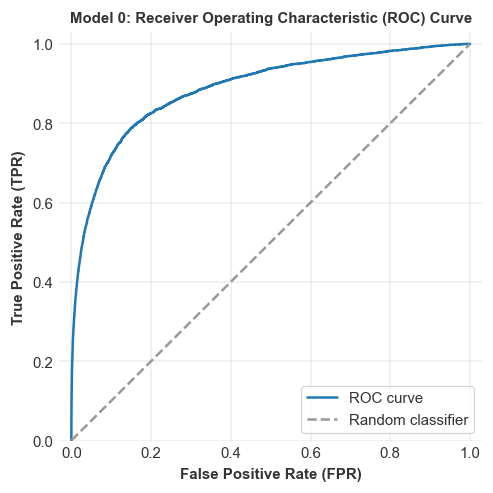

In [12]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

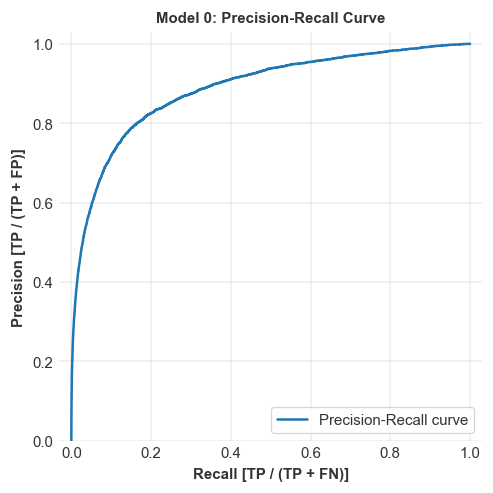

In [13]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

In [14]:

# -----------------------------
# Precision@K / Recall@K curves
# -----------------------------

def precision_recall_at_k(
    y_true: np.ndarray,
    y_score: np.ndarray,
    ks=(100, 500, 1000, 5000, 10000, 20000, 50000),
) -> pd.DataFrame:
    """
    Compute Precision@K and Recall@K for a binary classifier ranking.

    Parameters
    ----------
    y_true : array-like (n,)
        Binary labels {0,1}.
    y_score : array-like (n,)
        Model scores (higher = more likely positive).
    ks : iterable of int
        Cutoffs.

    Returns
    -------
    DataFrame with columns: K, tp, precision_at_k, recall_at_k.
    """
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score, dtype=float)

    if y_true.ndim != 1 or y_score.ndim != 1 or y_true.shape[0] != y_score.shape[0]:
        raise ValueError("y_true and y_score must be 1D arrays of the same length.")

    n = y_true.shape[0]
    pos_total = int(y_true.sum())
    if pos_total == 0:
        raise ValueError("y_true contains no positives; recall is undefined.")

    # sort descending by score
    order = np.argsort(-y_score, kind="mergesort")  # stable for ties
    y_sorted = y_true[order]

    # cumulative true positives along the ranked list
    ctp = np.cumsum(y_sorted)

    rows = []
    for K in ks:
        k = int(min(max(K, 1), n))
        tp = int(ctp[k - 1])
        precision = tp / k
        recall = tp / pos_total
        rows.append((k, tp, precision, recall))

    return pd.DataFrame(rows, columns=["K", "tp", "precision_at_k", "recall_at_k"])


def plot_precision_recall_at_k(pr_df: pd.DataFrame, title_prefix: str = "Validation"):
    """
    Plot Precision@K and Recall@K vs K (log-scaled x-axis).
    """
    ks = pr_df["K"].to_numpy()
    prec = pr_df["precision_at_k"].to_numpy()
    rec = pr_df["recall_at_k"].to_numpy()

    plt.figure(figsize=(9, 5))
    plt.plot(ks, prec, marker="o")
    plt.xscale("log")
    plt.xlabel("K (top-K flagged; log scale)")
    plt.ylabel("Precision@K")
    plt.title(f"{title_prefix}: Precision@K")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

    plt.figure(figsize=(9, 5))
    plt.plot(ks, rec, marker="o")
    plt.xscale("log")
    plt.xlabel("K (top-K flagged; log scale)")
    plt.ylabel("Recall@K")
    plt.title(f"{title_prefix}: Recall@K")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()



       K    tp  precision_at_k  recall_at_k
0    100    25         0.25000     0.004679
1    500   108         0.21600     0.020213
2   1000   172         0.17200     0.032192
3   5000   461         0.09220     0.086281
4  10000   713         0.07130     0.133446
5  20000   999         0.04995     0.186974
6  50000  1447         0.02894     0.270822


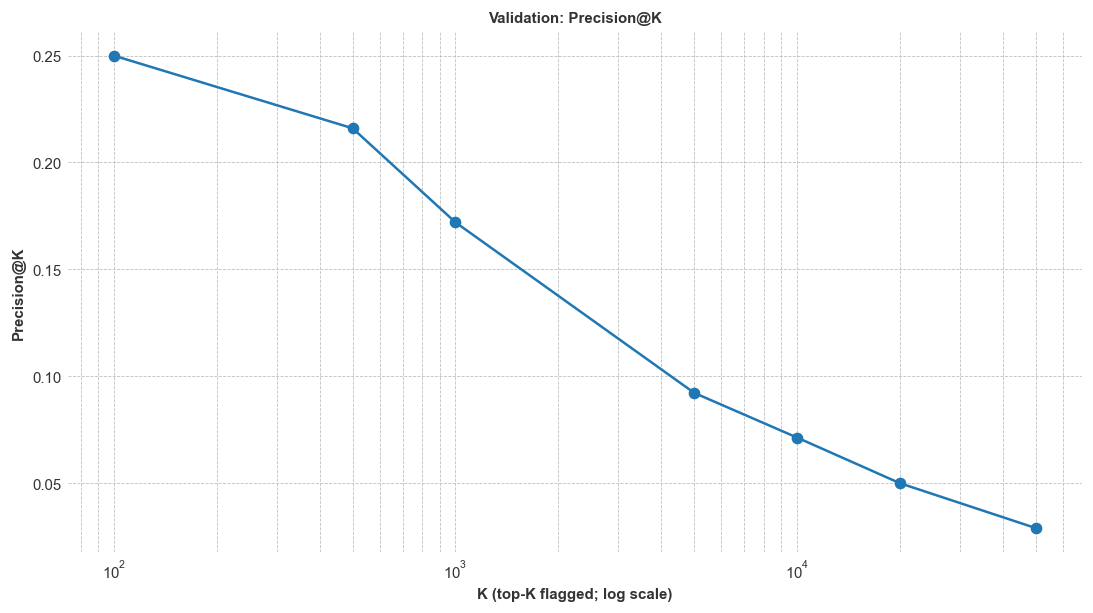

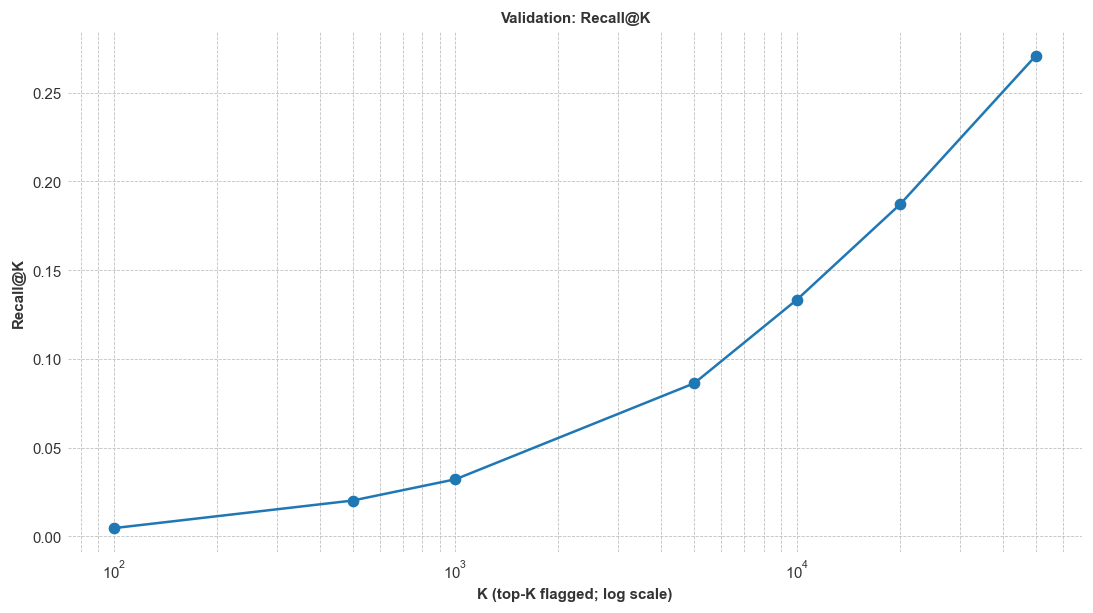

In [15]:
Ks = (100, 500, 1000, 5000, 10000, 20000, 50000)

pr_valid = precision_recall_at_k(y_valid.to_numpy(), p_valid, ks=Ks)
print(pr_valid)

plot_precision_recall_at_k(pr_valid, title_prefix="Validation")


#### Feature importance


In [16]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
21,ab_nicu,1.340228e+06
46,mage_c,9.231569e+05
43,dbwt,4.731174e+05
35,ca_disor,4.077559e+05
45,bmi,2.987847e+05
27,ca_cchd,2.628215e+05
44,wtgain,2.530425e+05
47,fagecomb,1.999982e+05
3,gestrec10,1.946071e+05
19,ab_aven1,1.557357e+05


### Evaluation subset for permutation importances and SHAP analysis


In [17]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

In [18]:
model_wrapped = ml_utils.LGBMEstimator(gbm)

In [19]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
35,ca_disor,1.111177e-02,0.000246
27,ca_cchd,1.019679e-02,0.000450
46,mage_c,9.328006e-03,0.000560
21,ab_nicu,5.497906e-03,0.000618
43,dbwt,3.241128e-03,0.000357
3,gestrec10,2.536440e-03,0.000310
16,dmeth_rec,2.110239e-03,0.000315
20,ab_aven6,1.276322e-03,0.000191
44,wtgain,1.014631e-03,0.000305
19,ab_aven1,7.982830e-04,0.000221


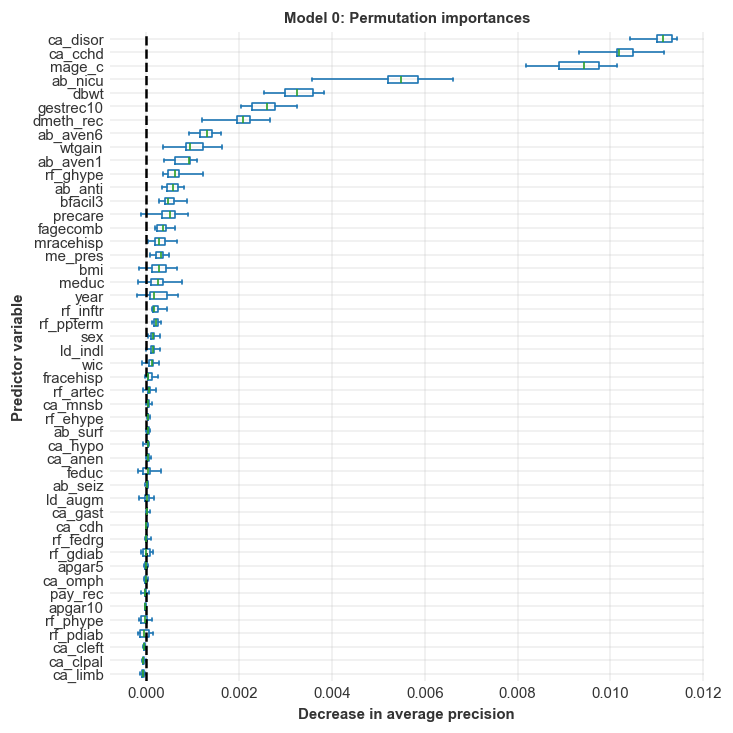

In [20]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

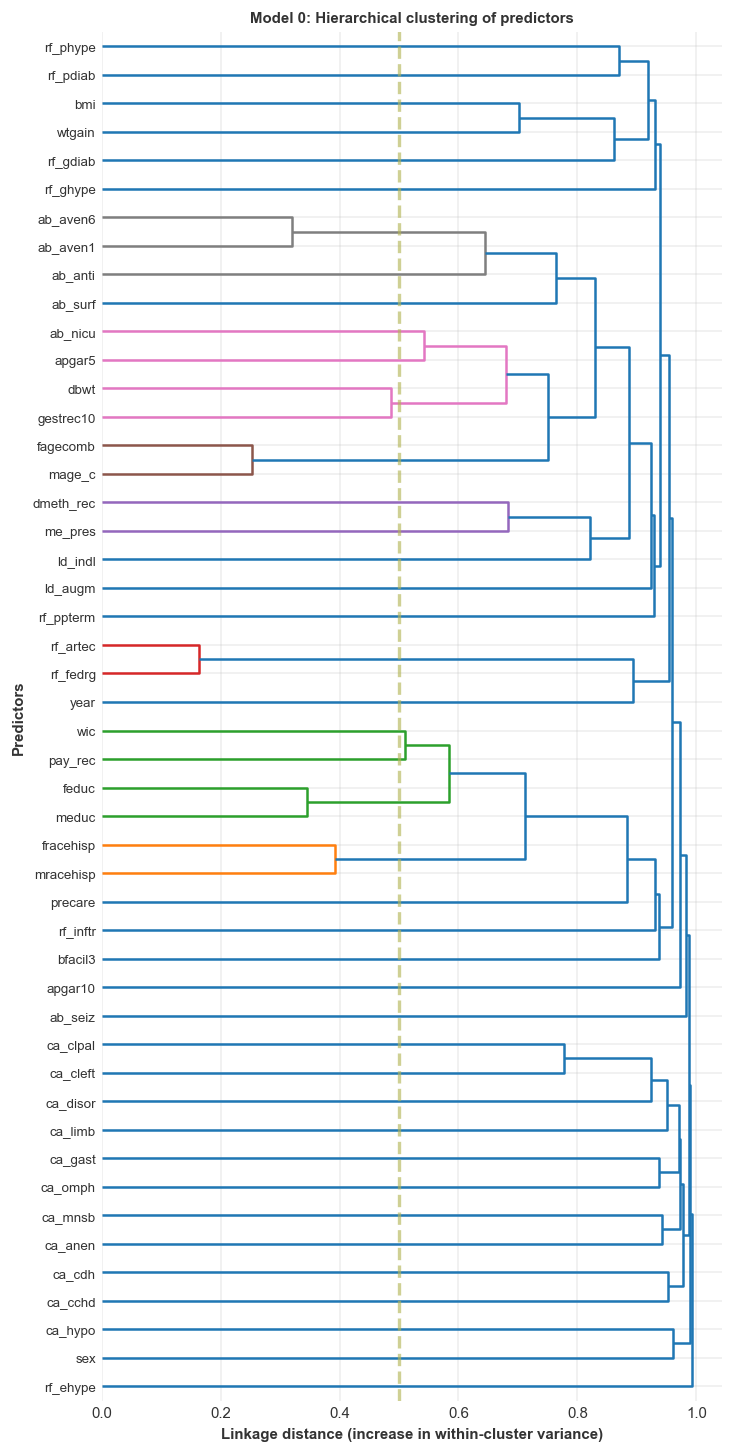

In [21]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

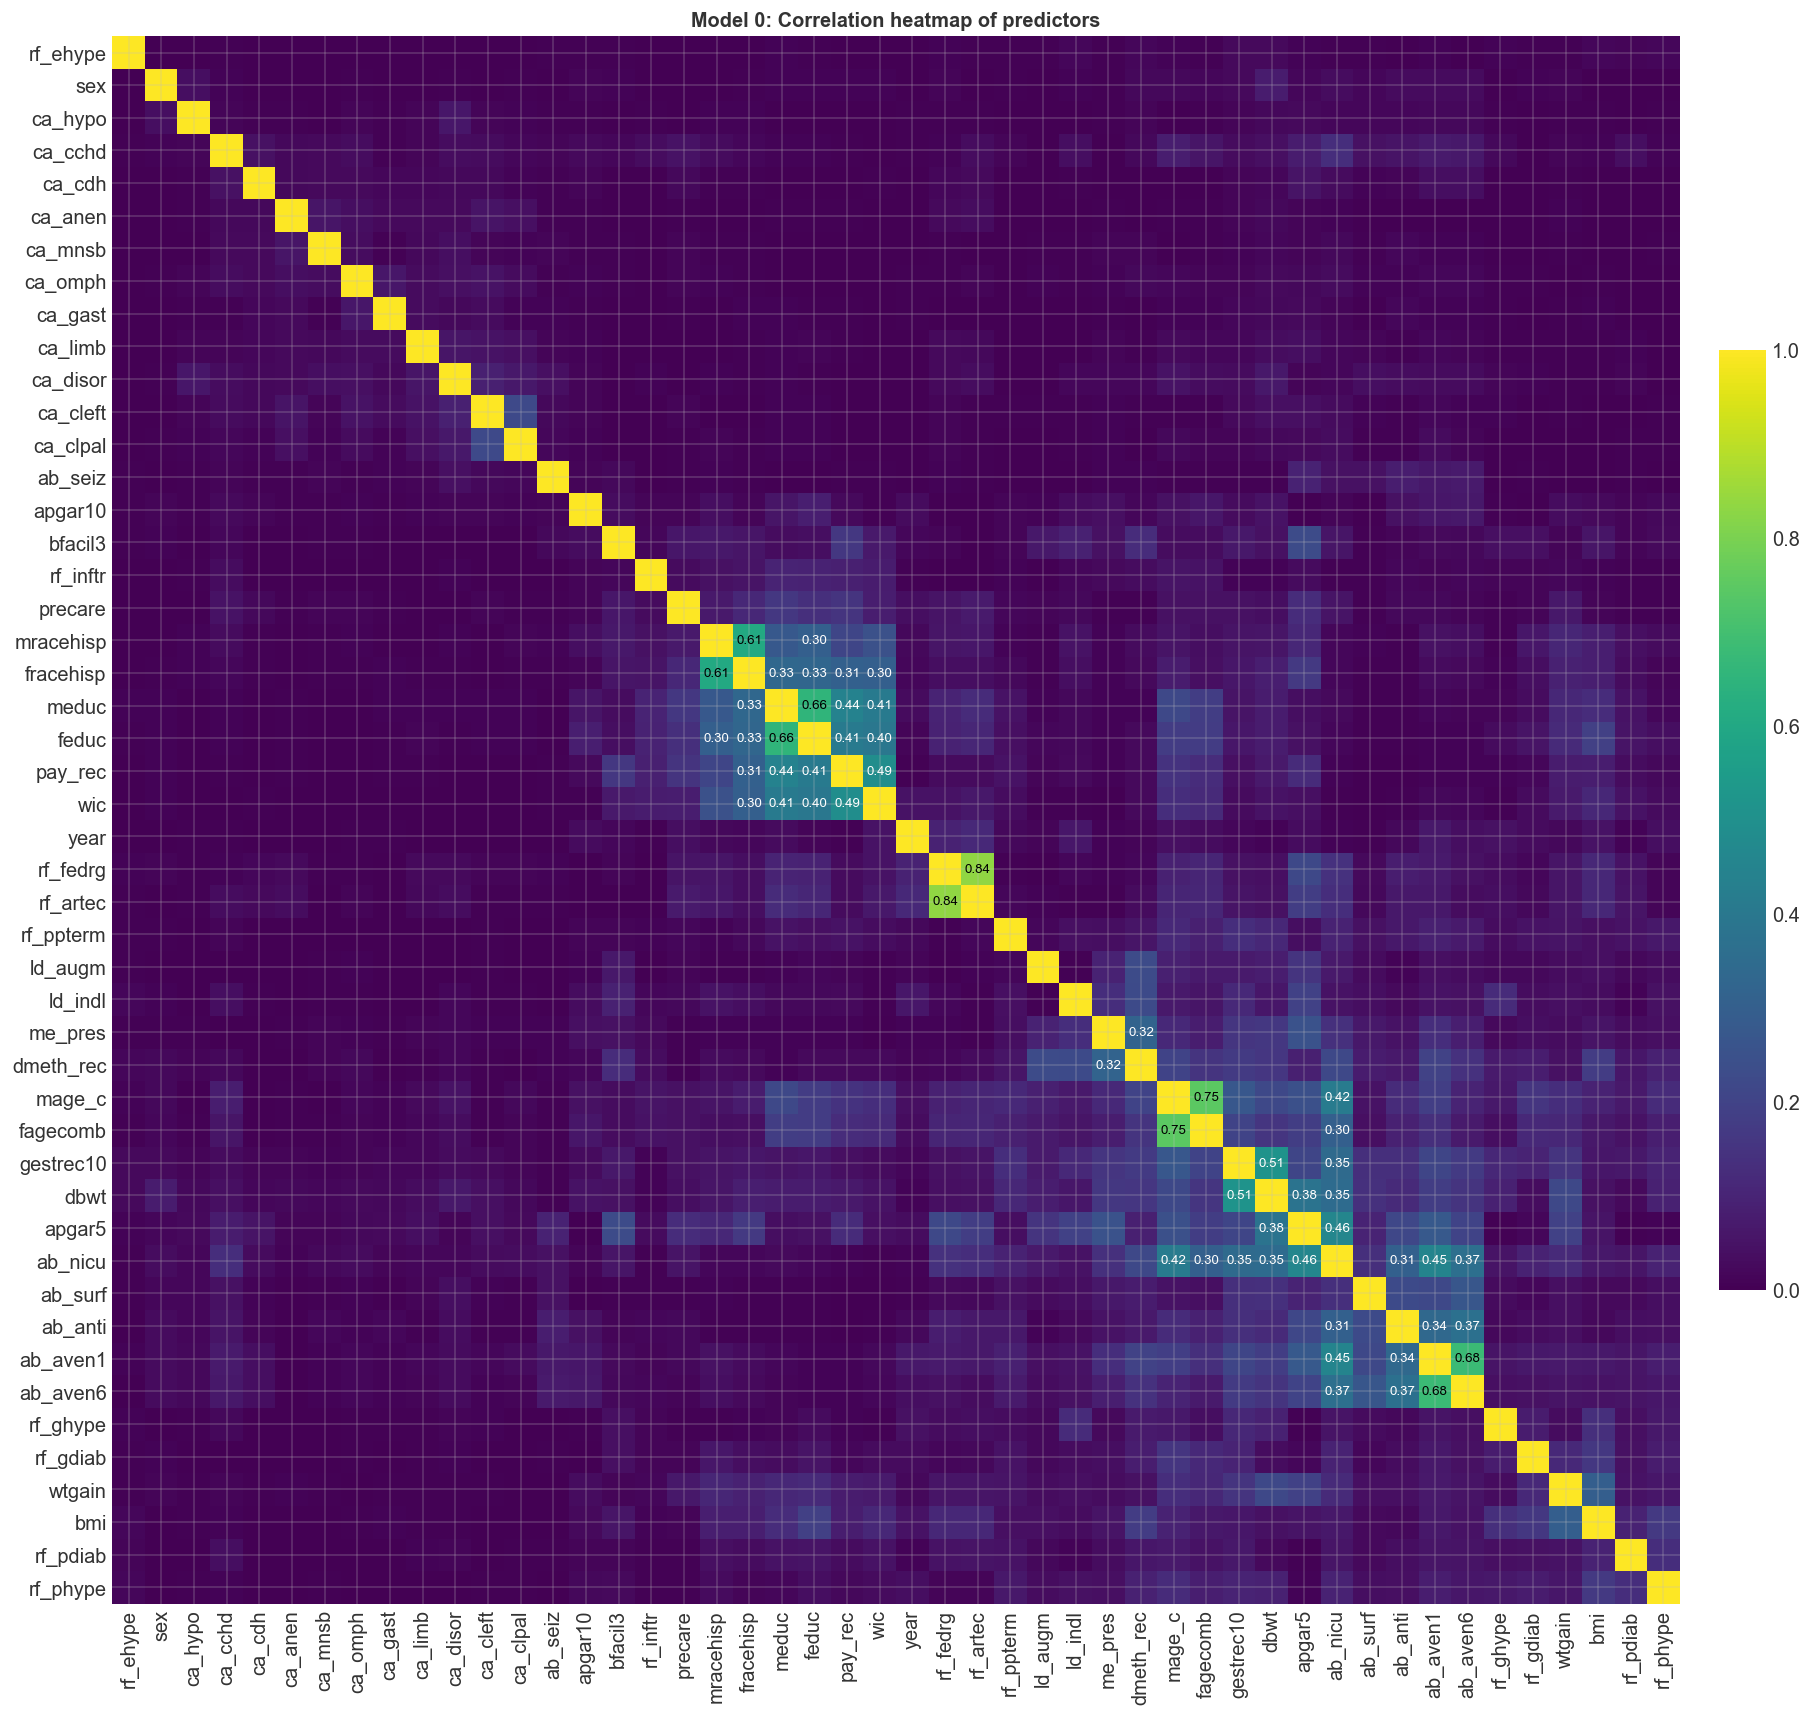

In [22]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [23]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\

,feature,mean_abs_shap
21,ab_nicu,0.895916
46,mage_c,0.745771
43,dbwt,0.330391
3,gestrec10,0.287948
19,ab_aven1,0.204585
37,mracehisp,0.113447
27,ca_cchd,0.095303
44,wtgain,0.091942
35,ca_disor,0.086029
20,ab_aven6,0.065084


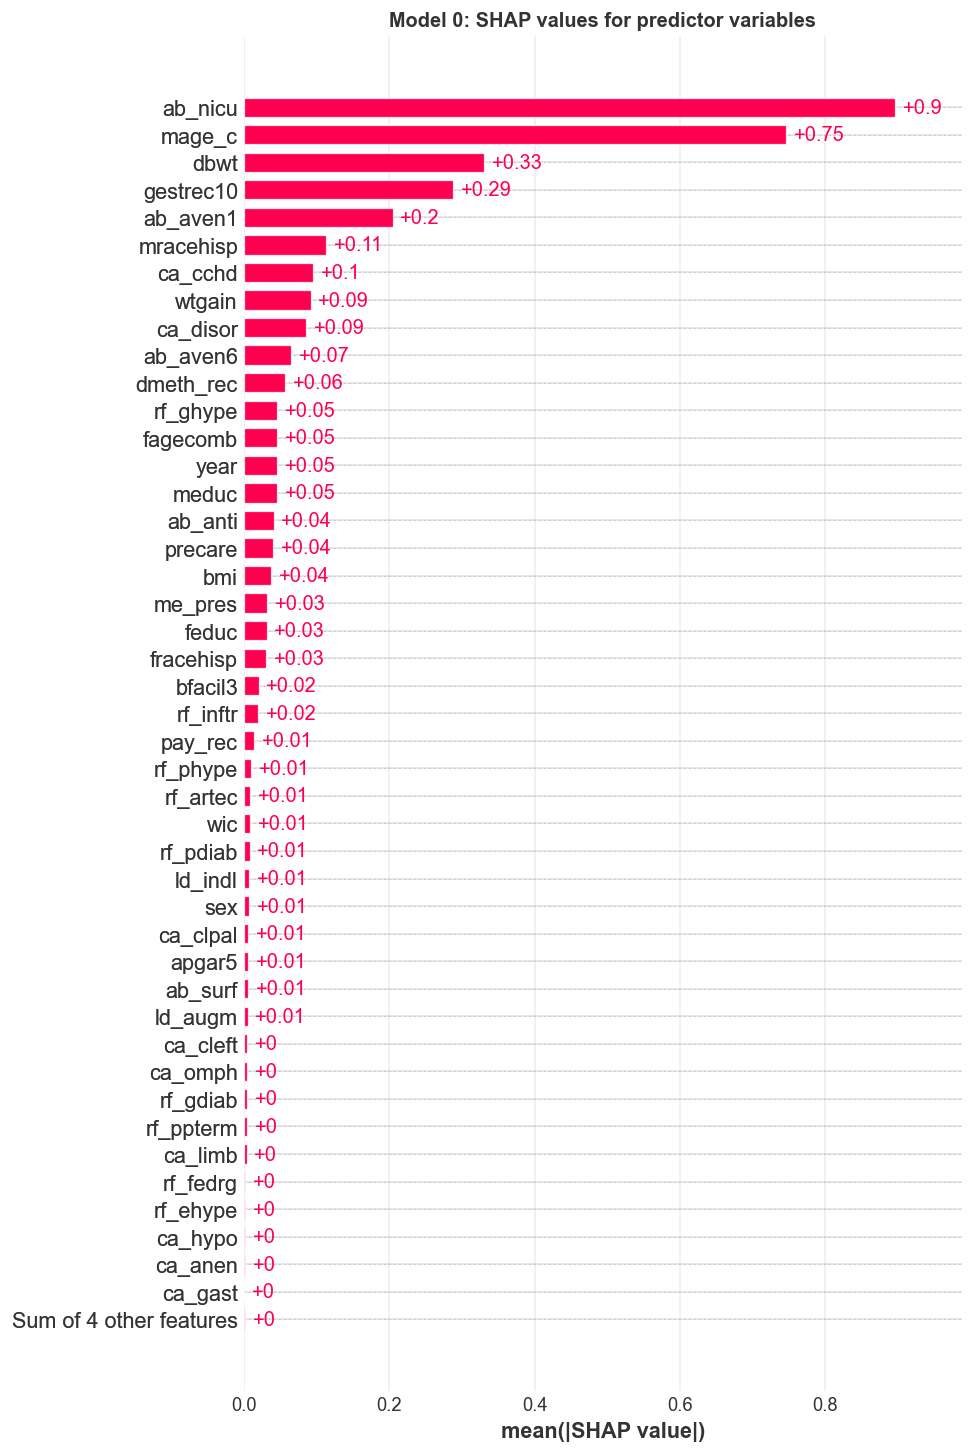

<Figure size 492x348 with 0 Axes>

In [24]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 12))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=45, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

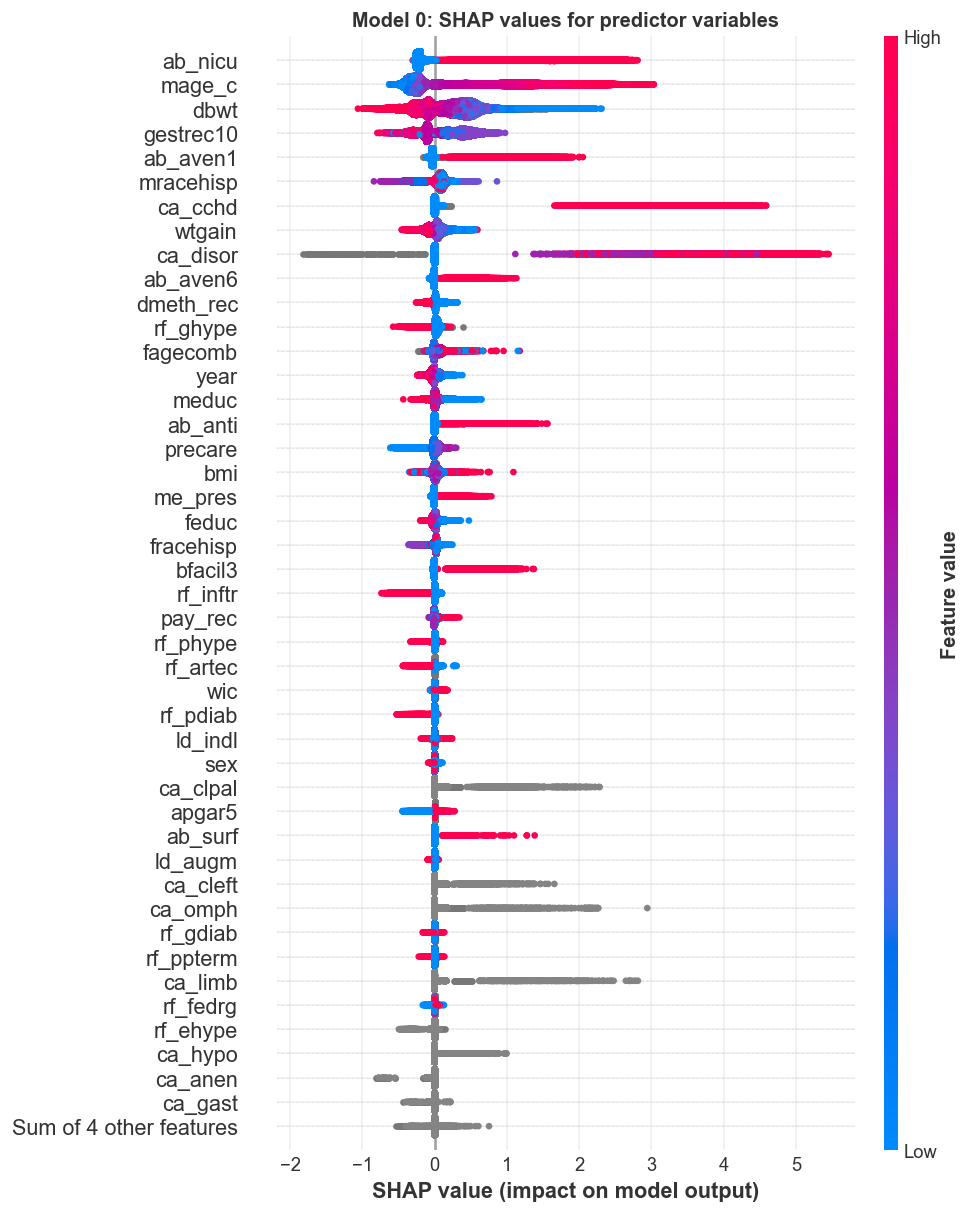

<Figure size 492x348 with 0 Axes>

In [25]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=45, plot_size=(8, 10))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

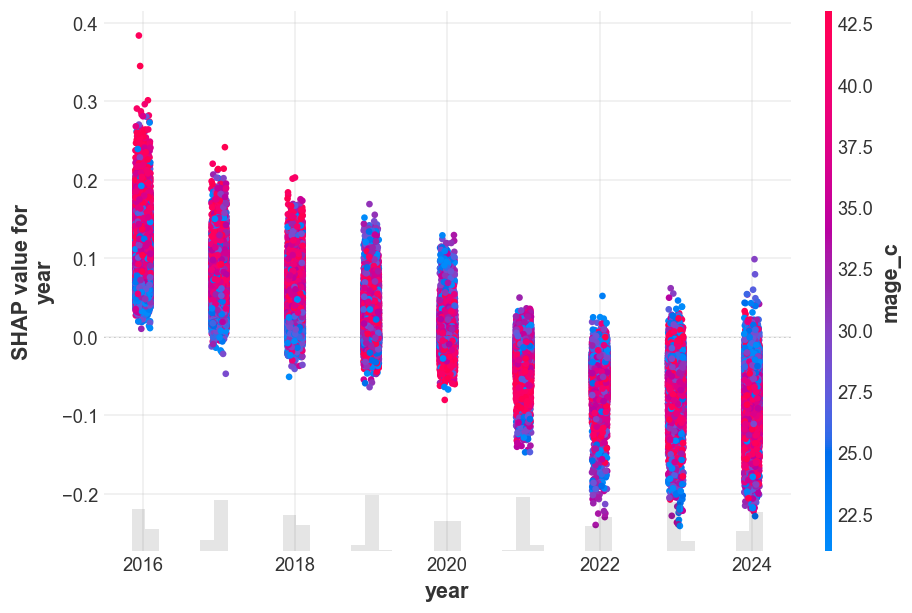

<Figure size 492x348 with 0 Axes>

In [26]:
ax = shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
# ax.set_title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Model 1


In [27]:
features_to_remove_0 = [
    "ca_cdh",
    "apgar10",
    "ca_cleft",
    "rf_artec",
    "ca_omph",
    "ca_clpal",
    "wic",
    "ca_limb"
]

X_train = X_train.drop(columns=features_to_remove_0)
X_valid = X_valid.drop(columns=features_to_remove_0)

features = X_train.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_0]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 1
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_0)} predictors)"
)

print(f"Features removed: {features_to_remove_0}")
print(f"Features remaining: {features}")
print(f"Number of features in {model_name}: {X_train.shape[1]}")

Features removed: ['ca_cdh', 'apgar10', 'ca_cleft', 'rf_artec', 'ca_omph', 'ca_clpal', 'wic', 'ca_limb']
Features remaining: ['bfacil3', 'sex', 'precare', 'gestrec10', 'rf_pdiab', 'rf_gdiab', 'rf_phype', 'rf_ghype', 'rf_ehype', 'rf_ppterm', 'rf_inftr', 'rf_fedrg', 'ld_indl', 'ld_augm', 'me_pres', 'dmeth_rec', 'apgar5', 'ab_aven1', 'ab_aven6', 'ab_nicu', 'ab_surf', 'ab_anti', 'ab_seiz', 'ca_anen', 'ca_mnsb', 'ca_cchd', 'ca_gast', 'ca_hypo', 'ca_disor', 'meduc', 'mracehisp', 'feduc', 'fracehisp', 'pay_rec', 'year', 'dbwt', 'wtgain', 'bmi', 'mage_c', 'fagecomb']
Number of features in Model 1 (after removing 8 predictors): 40


In [28]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	train's average_precision: 0.0350501	train's binary_logloss: 0.00422812	valid's average_precision: 0.0261176	valid's binary_logloss: 0.00426389
[20]	train's average_precision: 0.0387897	train's binary_logloss: 0.00410587	valid's average_precision: 0.0271071	valid's binary_logloss: 0.00415798
[30]	train's average_precision: 0.0409744	train's binary_logloss: 0.00402139	valid's average_precision: 0.0273641	valid's binary_logloss: 0.00408578
[40]	train's average_precision: 0.0429298	train's binary_logloss: 0.0039517	valid's average_precision: 0.0279891	valid's binary_logloss: 0.00402619
[50]	t

In [29]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [30]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds, tp, fp, n_pos = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.886777
1,Validation AP,0.030695
2,Validation log loss,0.003613
3,Precision at 10000,0.071100
4,Recall at 10000,0.133071
5,Precision (threshold=0.01),0.029178
6,Recall (threshold=0.01),0.271757


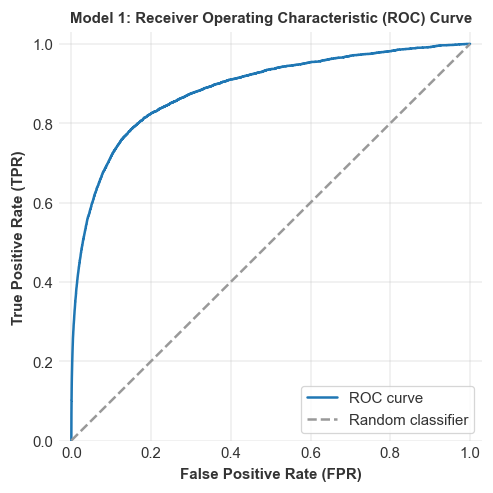

In [31]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

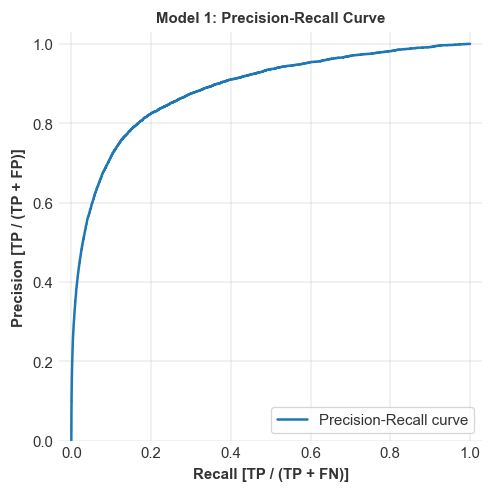

In [32]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

In [33]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
19,ab_nicu,1.333777e+06
38,mage_c,9.454631e+05
35,dbwt,4.624249e+05
28,ca_disor,4.021380e+05
37,bmi,2.804674e+05
25,ca_cchd,2.559124e+05
36,wtgain,2.430994e+05
3,gestrec10,1.950956e+05
39,fagecomb,1.936788e+05
17,ab_aven1,1.784384e+05


In [34]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

model_wrapped = ml_utils.LGBMEstimator(gbm)

In [35]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
28,ca_disor,0.010739,0.000480
25,ca_cchd,0.010728,0.000396
38,mage_c,0.009307,0.000451
19,ab_nicu,0.005276,0.000413
35,dbwt,0.003418,0.000290
3,gestrec10,0.002405,0.000311
15,dmeth_rec,0.002304,0.000241
17,ab_aven1,0.001600,0.000302
36,wtgain,0.001076,0.000218
18,ab_aven6,0.001061,0.000182


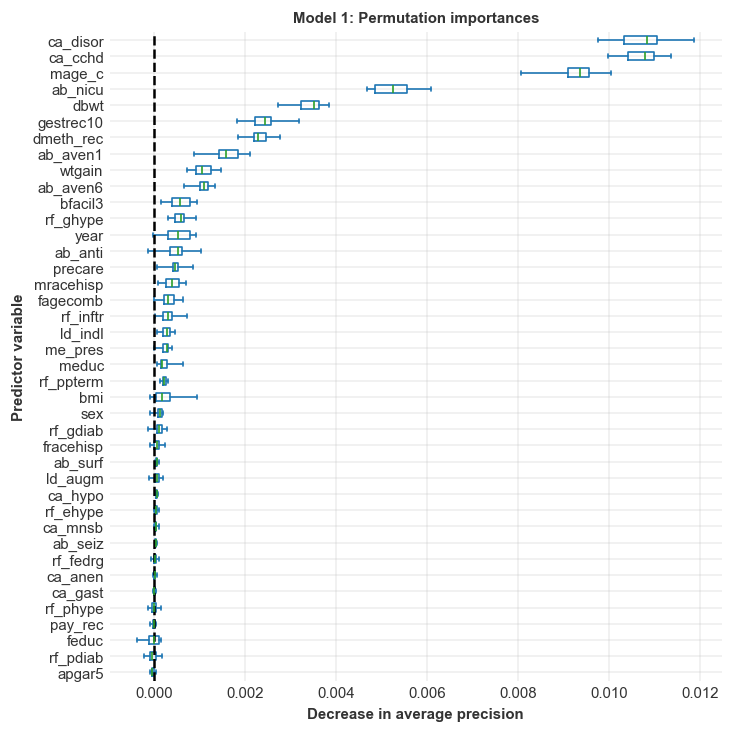

In [36]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

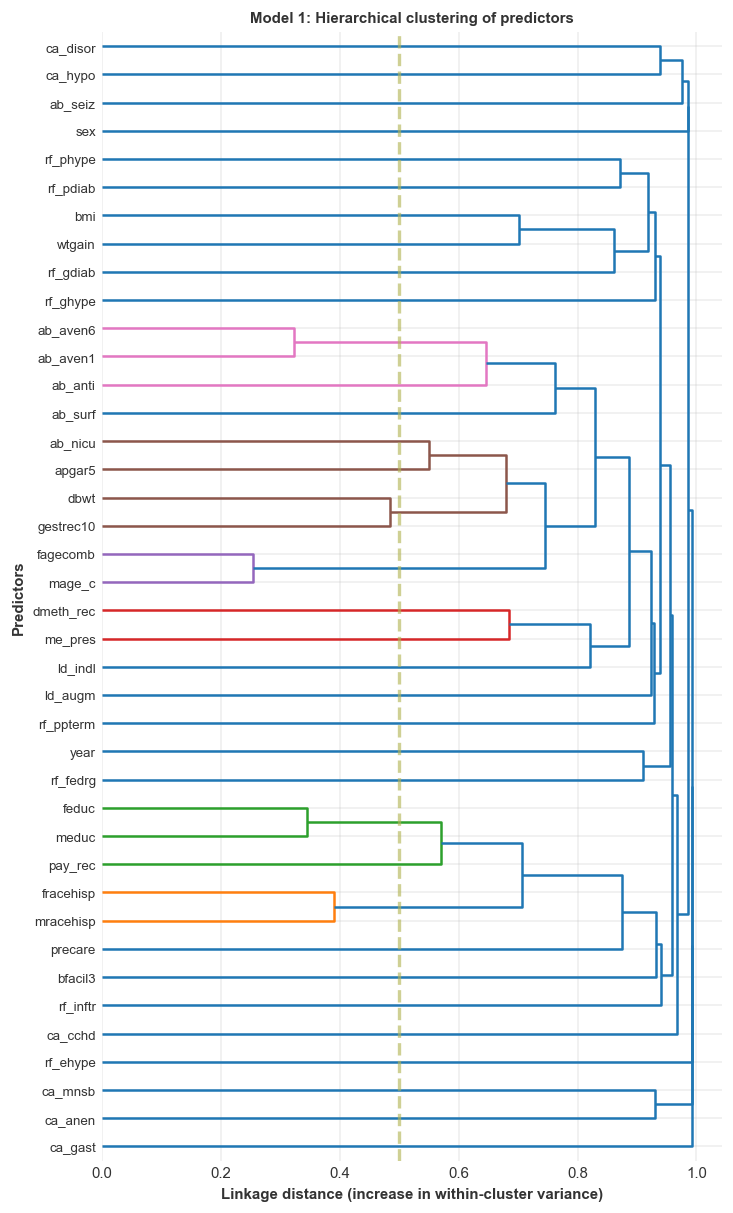

In [37]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

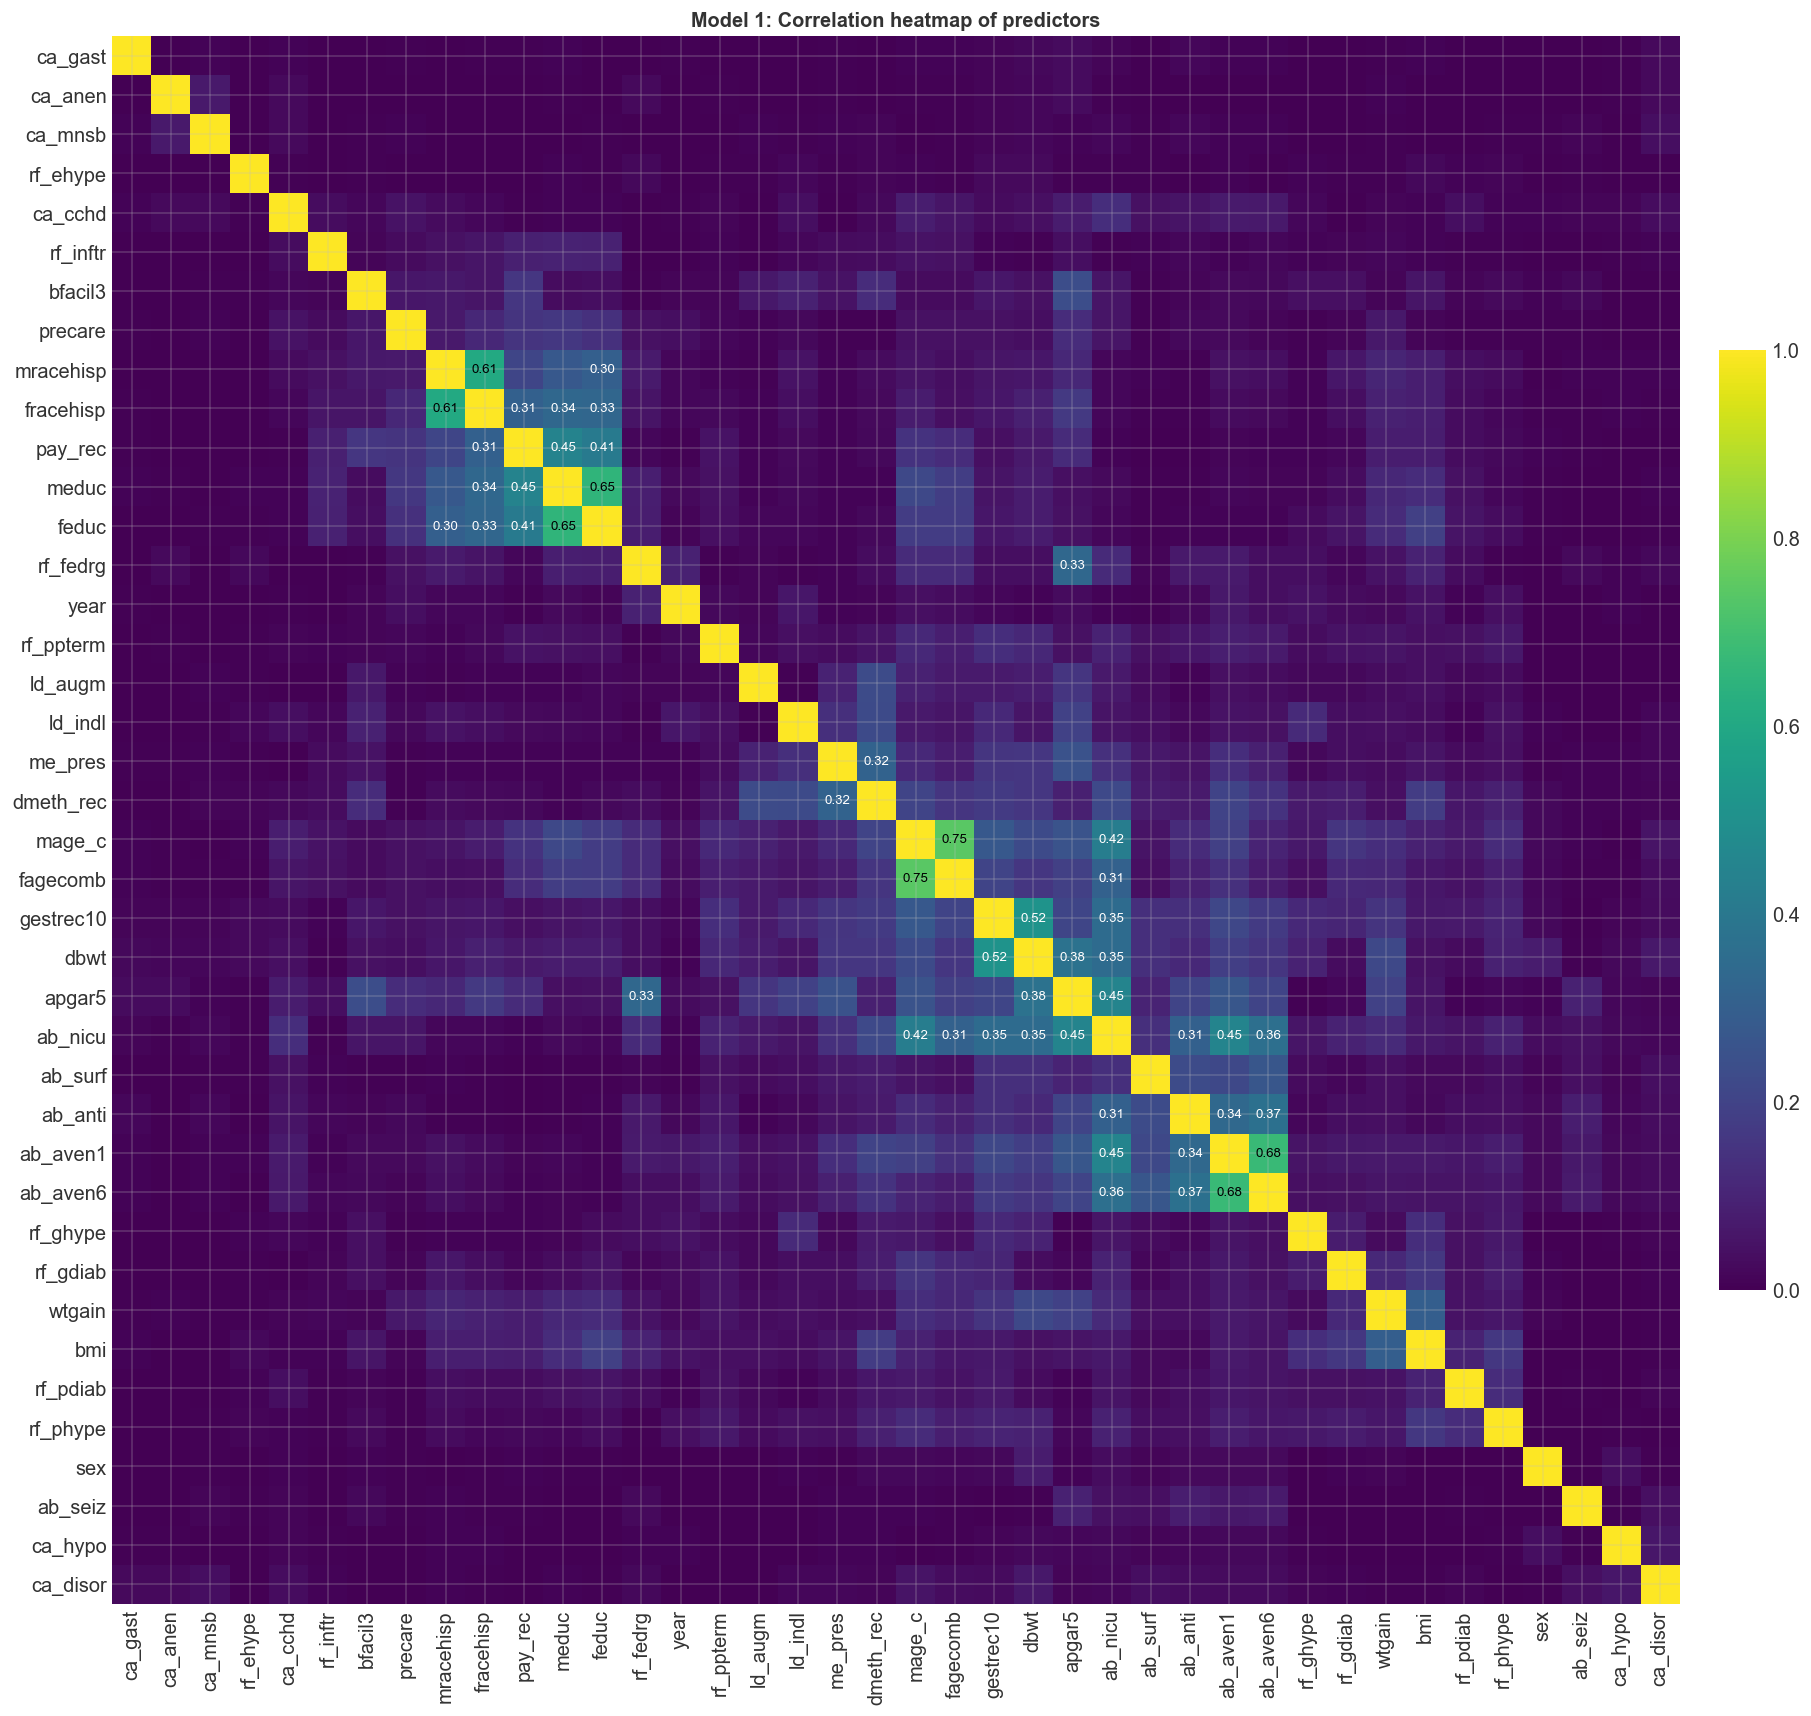

In [38]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [39]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\

,feature,mean_abs_shap
19,ab_nicu,0.892830
38,mage_c,0.740331
35,dbwt,0.326710
3,gestrec10,0.282764
17,ab_aven1,0.208735
30,mracehisp,0.110335
25,ca_cchd,0.099592
36,wtgain,0.091000
28,ca_disor,0.088808
18,ab_aven6,0.060114


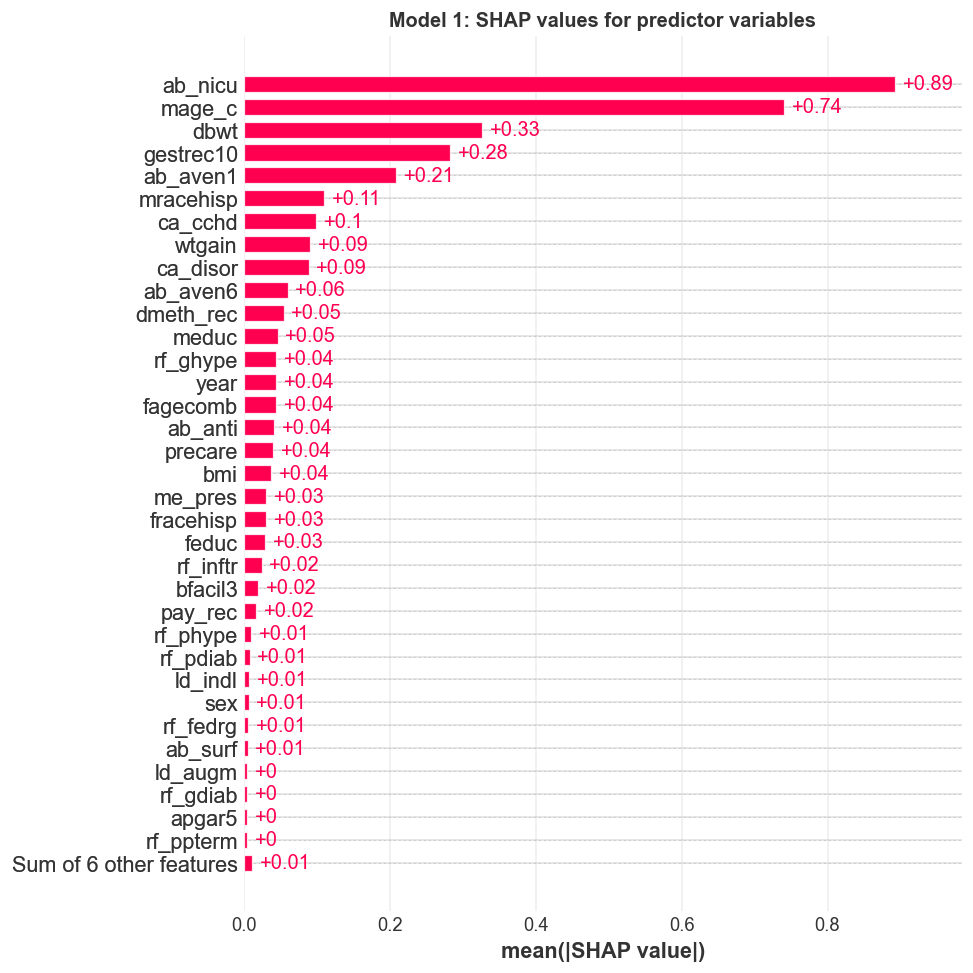

<Figure size 492x348 with 0 Axes>

In [40]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

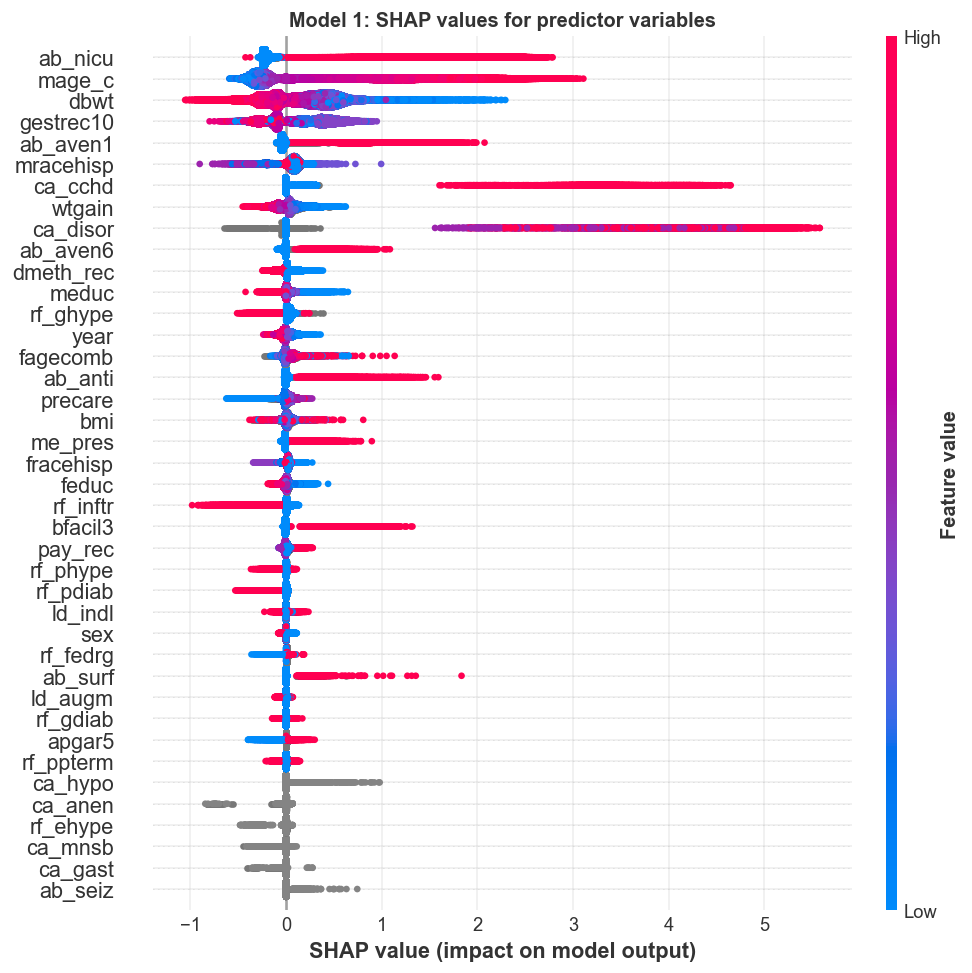

<Figure size 492x348 with 0 Axes>

In [41]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=40, plot_size=(8, 8))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

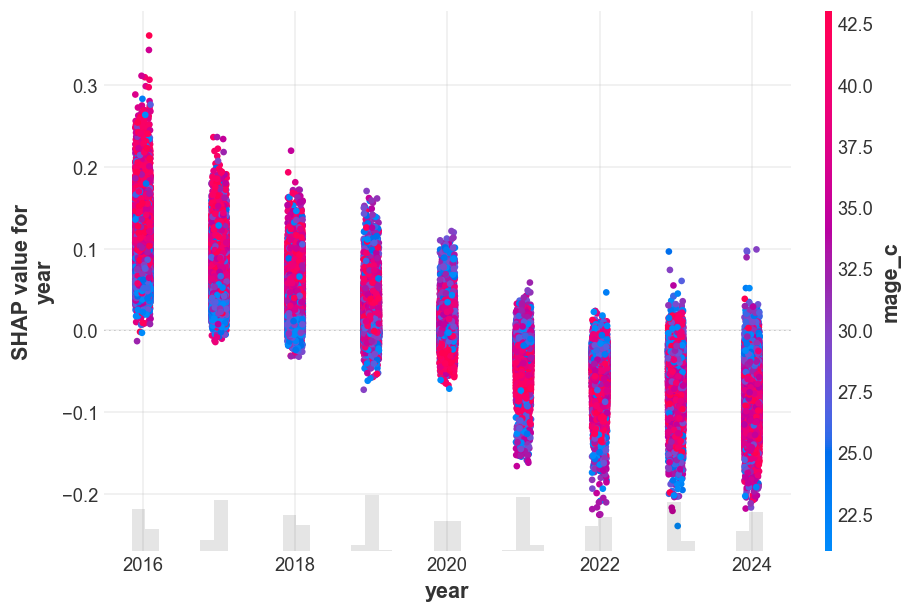

<Figure size 492x348 with 0 Axes>

In [42]:
shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
#plt.title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Model 2


In [43]:
features_to_remove_1 = [
    "rf_pdiab",
    "ca_hypo",
    "rf_ppterm",
    "ca_mnsb",
    "rf_ehype",
    "ca_anen",
    "ca_gast",
    "ab_surf",
    "rf_gdiab",
    "ab_seiz",
]

X_train = X_train.drop(columns=features_to_remove_1)
X_valid = X_valid.drop(columns=features_to_remove_1)

features = X_train.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_1]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 2
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_1)} predictors)"
)

print(f"Features removed: {features_to_remove_1}")
print(f"Features remaining: {features}")
print(f"Number of features in {model_name}: {X_train.shape[1]}")

Features removed: ['rf_pdiab', 'ca_hypo', 'rf_ppterm', 'ca_mnsb', 'rf_ehype', 'ca_anen', 'ca_gast', 'ab_surf', 'rf_gdiab', 'ab_seiz']
Features remaining: ['bfacil3', 'sex', 'precare', 'gestrec10', 'rf_phype', 'rf_ghype', 'rf_inftr', 'rf_fedrg', 'ld_indl', 'ld_augm', 'me_pres', 'dmeth_rec', 'apgar5', 'ab_aven1', 'ab_aven6', 'ab_nicu', 'ab_anti', 'ca_cchd', 'ca_disor', 'meduc', 'mracehisp', 'feduc', 'fracehisp', 'pay_rec', 'year', 'dbwt', 'wtgain', 'bmi', 'mage_c', 'fagecomb']
Number of features in Model 2 (after removing 10 predictors): 30


In [44]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 839
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 200 rounds
[10]	train's average_precision: 0.0365288	train's binary_logloss: 0.00423333	valid's average_precision: 0.0262704	valid's binary_logloss: 0.00426892
[20]	train's average_precision: 0.0389442	train's binary_logloss: 0.00412144	valid's average_precision: 0.0268559	valid's binary_logloss: 0.00417216
[30]	train's average_precision: 0.0414914	train's binary_logloss: 0.00402818	valid's average_precision: 0.027645	valid's binary_logloss: 0.00409134
[40]	train's average_precision: 0.0432933	train's binary_logloss: 0.00395381	valid's average_precision: 0.0280802	valid's binary_logloss: 0.00402715
[50]	t

In [45]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [46]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds, tp, fp, n_pos = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.887006
1,Validation AP,0.030966
2,Validation log loss,0.003612
3,Precision at 10000,0.070500
4,Recall at 10000,0.131948
5,Precision (threshold=0.01),0.027964
6,Recall (threshold=0.01),0.278870


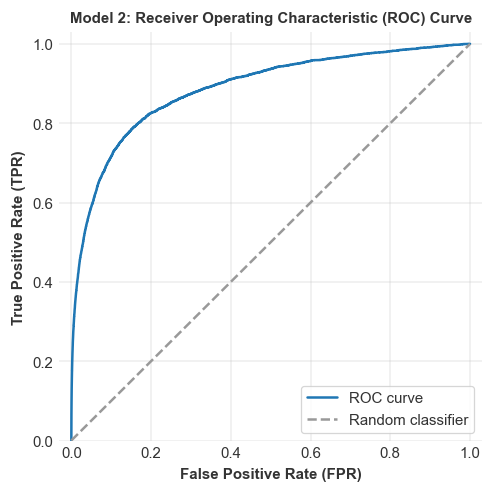

In [47]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

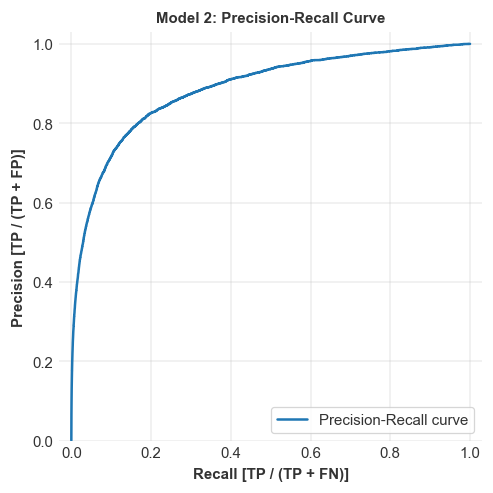

In [48]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

       K    tp  precision_at_k  recall_at_k
0    100    29          0.2900     0.005428
1    500   111          0.2220     0.020775
2   1000   175          0.1750     0.032753
3   5000   474          0.0948     0.088714
4  10000   705          0.0705     0.131948
5  20000   988          0.0494     0.184915
6  50000  1460          0.0292     0.273255


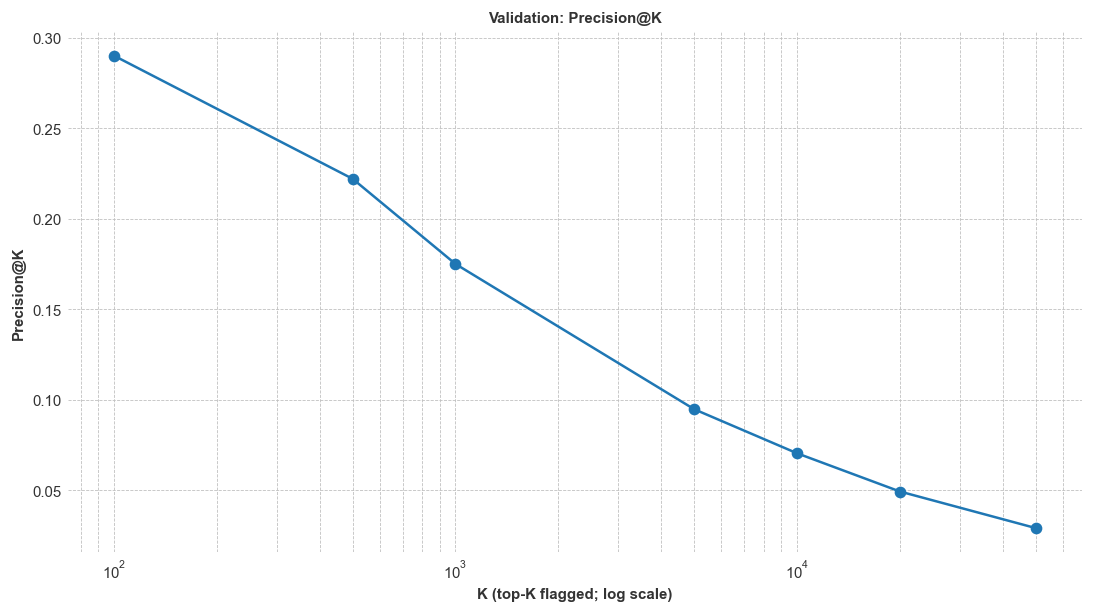

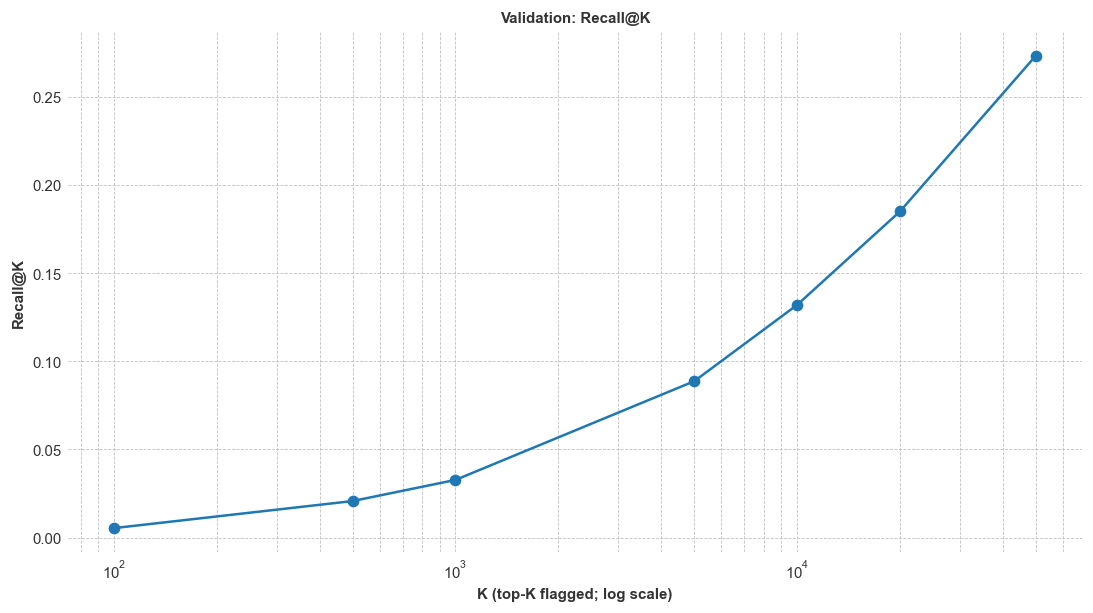

In [49]:

pr_valid = precision_recall_at_k(y_valid.to_numpy(), p_valid, ks=Ks)
print(pr_valid)

plot_precision_recall_at_k(pr_valid, title_prefix="Validation")


In [50]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
15,ab_nicu,1.330984e+06
28,mage_c,9.848980e+05
25,dbwt,6.685932e+05
27,bmi,5.062286e+05
18,ca_disor,4.120586e+05
26,wtgain,4.102484e+05
29,fagecomb,3.601196e+05
17,ca_cchd,2.720816e+05
3,gestrec10,2.110846e+05
13,ab_aven1,1.997762e+05


In [51]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

model_wrapped = ml_utils.LGBMEstimator(gbm)

In [52]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
18,ca_disor,0.011425,0.000500
17,ca_cchd,0.011297,0.000344
28,mage_c,0.009807,0.000470
15,ab_nicu,0.005034,0.000677
25,dbwt,0.003935,0.000261
3,gestrec10,0.002609,0.000427
11,dmeth_rec,0.002593,0.000255
13,ab_aven1,0.001311,0.000275
26,wtgain,0.001240,0.000362
14,ab_aven6,0.000903,0.000102


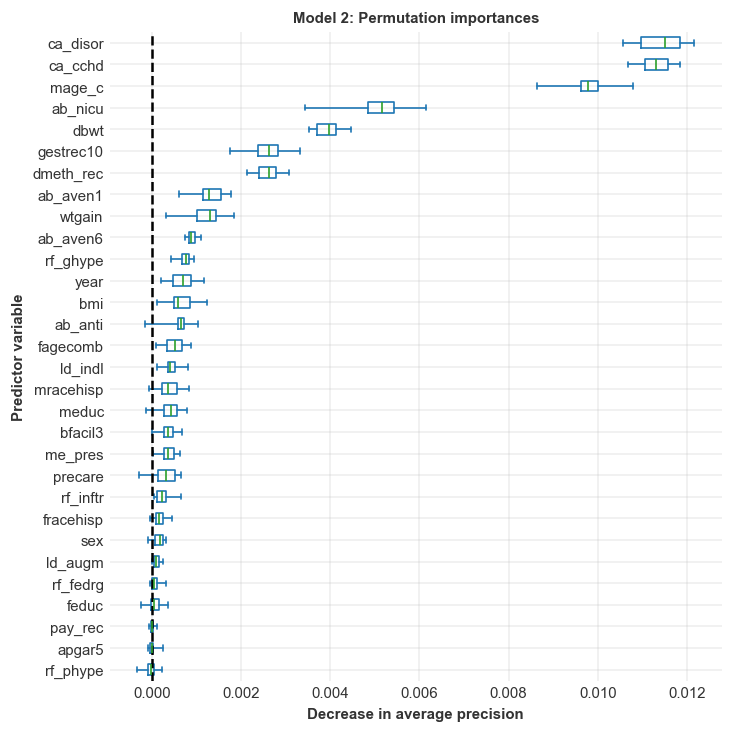

In [53]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

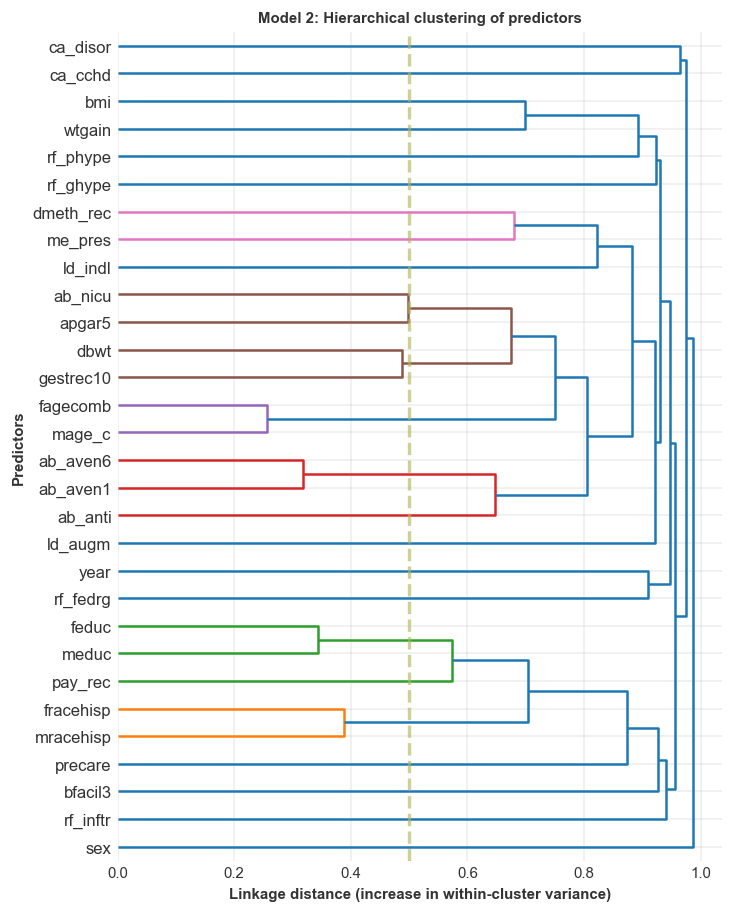

In [54]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

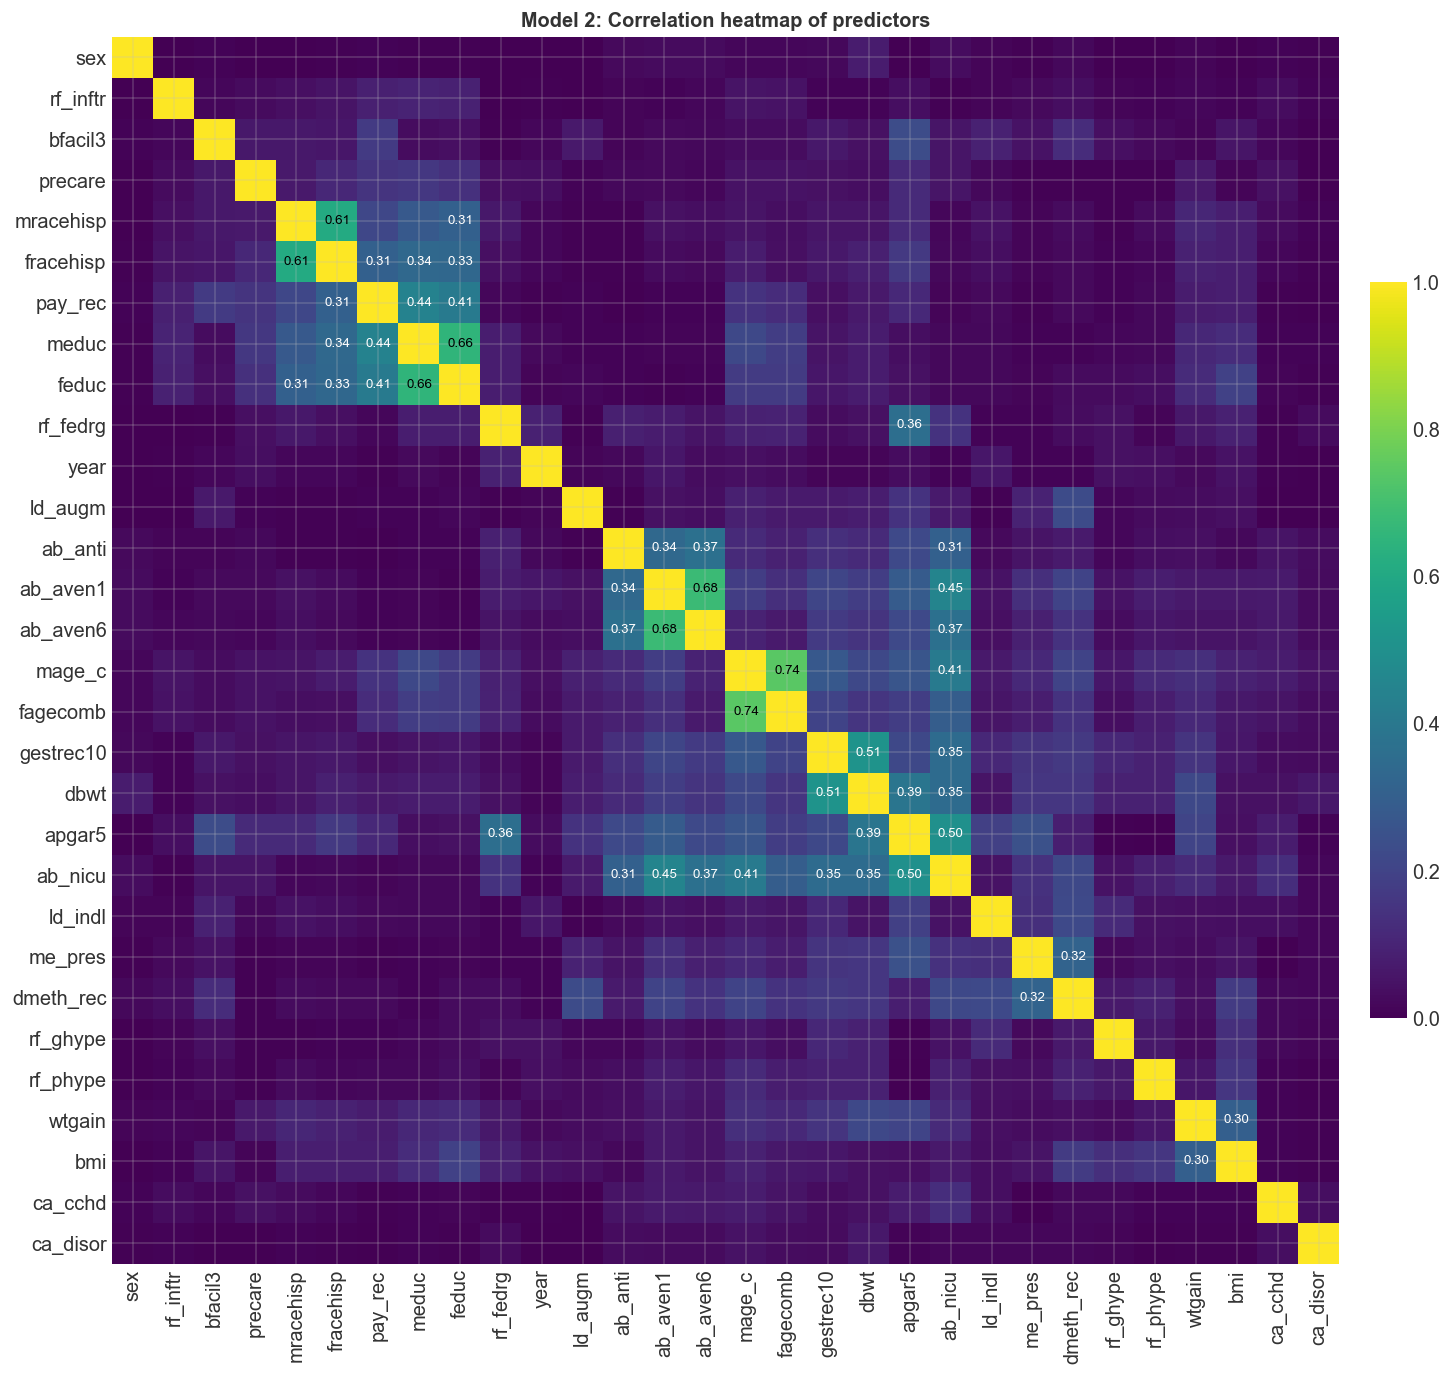

In [55]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [56]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\

,feature,mean_abs_shap
15,ab_nicu,0.906627
28,mage_c,0.768915
25,dbwt,0.366408
3,gestrec10,0.311112
13,ab_aven1,0.222353
20,mracehisp,0.133187
26,wtgain,0.104574
17,ca_cchd,0.101439
18,ca_disor,0.090150
11,dmeth_rec,0.066559


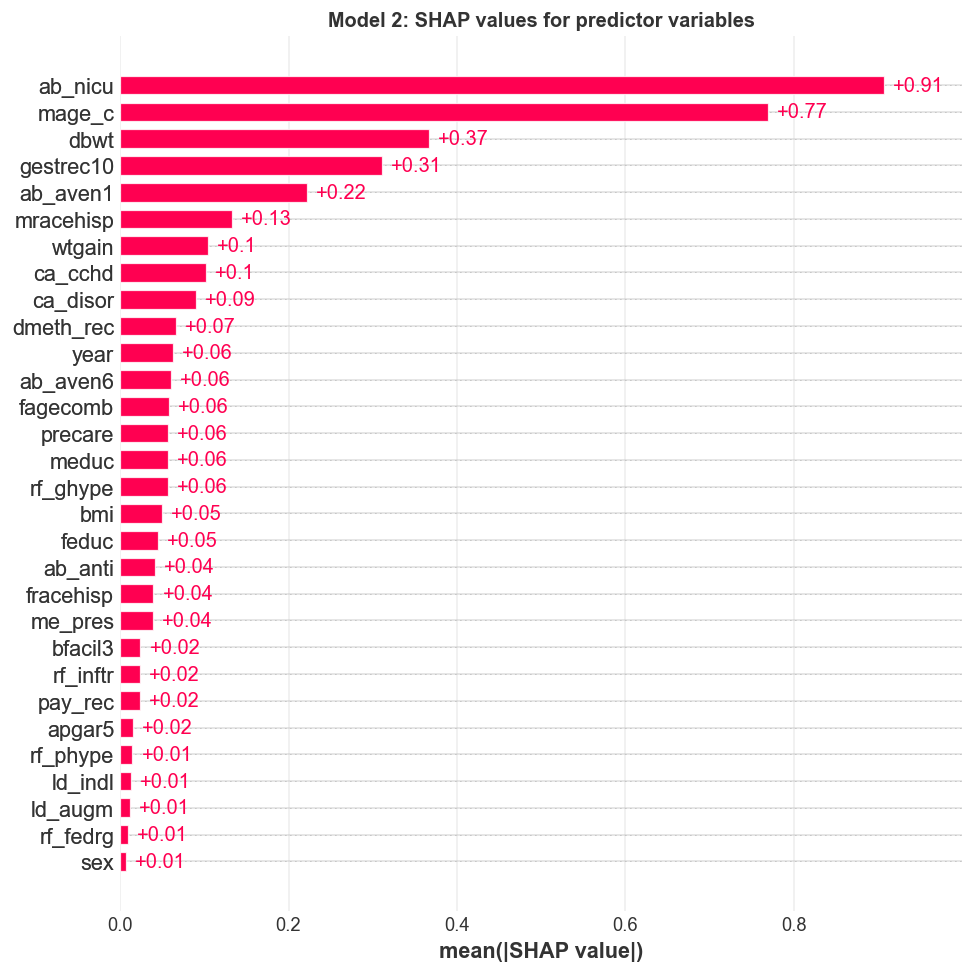

<Figure size 492x348 with 0 Axes>

In [57]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

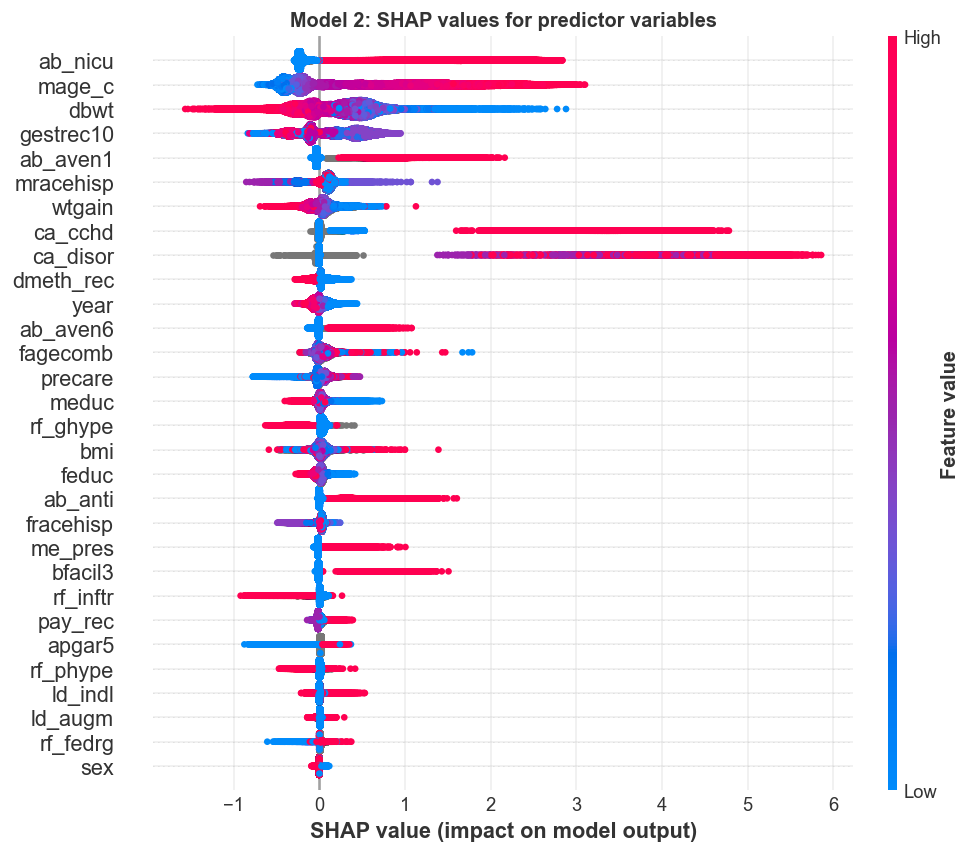

<Figure size 492x348 with 0 Axes>

In [58]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

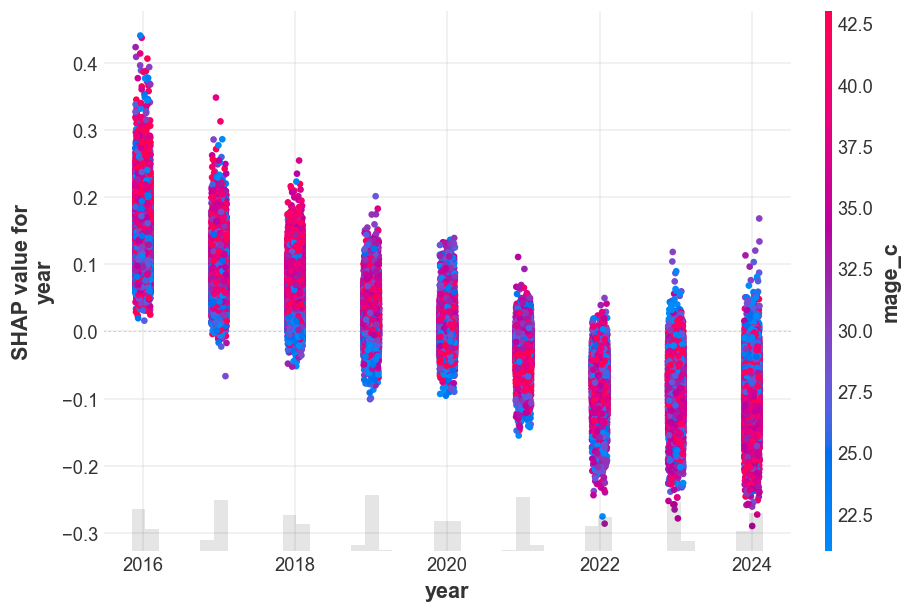

<Figure size 492x348 with 0 Axes>

In [59]:
ax = shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

In [60]:
# More SHAP plots...

## Prediction


In [61]:
p_valid = gbm.predict(X_valid, num_iteration=gbm.best_iteration, raw_score=False)

print("best_iteration:", gbm.best_iteration)
print("mean raw prob:", float(p_valid.mean()))


print("Raw logloss:", log_loss(y_valid, p_valid, labels=[0, 1]))
print("Raw brier:  ", brier_score_loss(y_valid, p_valid))

best_iteration: 1270
mean raw prob: 0.0005256478945158733
Raw logloss: 0.003611656060992212
Raw brier:   0.0005214100303897099


In [62]:
def tail_calibration_table(y, p, fracs=(1e-2, 1e-3, 1e-4, 1e-5)):
    """
    Compare predicted vs observed event rates in the top fracs of scores.

    Parameters
    ----------
    y : array-like (0/1)
    p : array-like (probabilities)
    fracs : iterable of floats
        Fractions like 1e-3 for top 0.1%.

    Returns
    -------
    DataFrame with k, predicted mean, observed rate, and counts.
    """
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)

    order = np.argsort(-p)
    y_sorted = y[order]
    p_sorted = p[order]

    N = len(y)
    rows = []
    for f in fracs:
        k = max(1, int(round(N * f)))
        y_top = y_sorted[:k]
        p_top = p_sorted[:k]

        obs_rate = y_top.mean()
        pred_rate = p_top.mean()

        tp = int(y_top.sum())
        fp = int(k - tp)

        rows.append(
            {
                "top_frac": f,
                "k": k,
                "pred_rate_mean": pred_rate,
                "obs_rate": obs_rate,
                "tp": tp,
                "fp": fp,
                "pred_minus_obs": pred_rate - obs_rate,
                "ratio_pred_to_obs": (pred_rate / obs_rate) if obs_rate > 0 else np.nan,
            }
        )

    return pd.DataFrame(rows)

In [63]:
fracs = (1e-2, 1e-3, 1e-4, 1e-5)  # 1%, 0.1%, 0.01%, 0.001%

calibration_table = tail_calibration_table(y_valid, p_valid, fracs=fracs)

calibration_table["model"] = "raw"

calibration_table.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_tail_calibration_table.csv",
    index=False,
)

calibration_table

,top_frac,k,pred_rate_mean,obs_rate,tp,fp,pred_minus_obs,ratio_pred_to_obs,model
0,0.01000,100768,0.018475,0.018548,1869,98899,-0.000073,0.996084,raw
1,0.00100,10077,0.076288,0.069961,705,9372,0.006326,1.090427,raw
2,0.00010,1008,0.226600,0.173611,175,833,0.052989,1.305217,raw
3,0.00001,101,0.403417,0.287129,29,72,0.116288,1.405003,raw


In [64]:
gbm.save_model(
    f"{OUTPUT_DIR}/final_model_{model_idx}.txt",
    num_iteration=best_iter,
)

In [65]:
X_full = df[features]

categorical = [col for col in categorical if col in X_full.columns]

X_full[categorical] = X_full[categorical].astype("category")

In [66]:
p_full = gbm.predict(X_full, num_iteration=gbm.best_iteration)  # P(S=1|X)

In [67]:
df["p_ds_lb_pred_01"] = p_full

In [68]:
df[["year", "p_ds_lb_pred_01", "ca_down_c_p_n"]].groupby(
    "year"
).sum().reset_index()

,year,p_ds_lb_pred_01,ca_down_c_p_n
0,2016,2133.837225,2168
1,2017,2040.630683,2044
2,2018,2039.524758,2108
3,2019,2007.759863,2030
4,2020,1935.455168,1954
5,2021,1943.192923,1903
6,2022,1879.083226,1861
7,2023,1892.746365,1855
8,2024,1904.369940,1886


In [69]:
import duckdb

con = duckdb.connect("./data/us_births.db")

In [70]:
con.execute(
    """
    ALTER TABLE us_births ADD COLUMN IF NOT EXISTS p_ds_lb_pred_01 DOUBLE;
    """
)
con.execute("DROP TABLE IF EXISTS ds_lb_pred_01")
con.execute(f"CREATE TABLE ds_lb_pred_01 (id BIGINT, p_ds_lb_pred DOUBLE)")

In [71]:
con.execute(
    """
    INSERT INTO ds_lb_pred_01 (id, p_ds_lb_pred)
    SELECT id, p_ds_lb_pred_01
    FROM df
    """
)

In [72]:
con.execute(
    """
    UPDATE us_births b
    SET p_ds_lb_pred_01 = p.p_ds_lb_pred
    FROM ds_lb_pred_01 p
    WHERE b.id = p.id;
    """
)

In [73]:
con.execute("DROP TABLE IF EXISTS ds_lb_pred_01")

In [74]:
con.close()